In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%qtconsole

In [2]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import logging
logging.basicConfig(level=logging.INFO)

In [3]:
from loren_frank_data_processing import (get_interpolated_position_dataframe,
                                         get_LFPs,
                                         get_multiunit_indicator_dataframe,
                                         get_spike_indicator_dataframe,
                                         make_tetrode_dataframe)

from ripple_detection import Kay_ripple_detector

_BRAIN_AREAS = 'CA1'

def detect_epoch_ripples(epoch_key, animals, sampling_frequency,
                         brain_areas=_BRAIN_AREAS,
                         minimum_duration=pd.Timedelta(milliseconds=15),
                         zscore_threshold=3):
    '''Returns a list of tuples containing the start and end times of
    ripples. Candidate ripples are computed via the ripple detection
    function and then filtered to exclude ripples where the animal was
    still moving.
    '''

    tetrode_info = make_tetrode_dataframe(animals).xs(
        epoch_key, drop_level=False)
    brain_areas = [brain_areas] if isinstance(
        brain_areas, str) else brain_areas
    is_brain_areas = tetrode_info.area.isin(brain_areas)
    if 'CA1' in brain_areas:
        is_brain_areas = is_brain_areas & tetrode_info.validripple
    tetrode_keys = tetrode_info[is_brain_areas].index
    lfps = get_LFPs(tetrode_keys, animals)
    time = lfps.index
    speed = get_interpolated_position_dataframe(
        epoch_key, animals).speed

    return Kay_ripple_detector(
        time, lfps.values, speed.values, sampling_frequency,
        minimum_duration=minimum_duration, zscore_threshold=zscore_threshold)

In [4]:
from collections import namedtuple
from os.path import join, abspath, dirname, pardir

# LFP sampling frequency
SAMPLING_FREQUENCY = 1500

# Data directories and definitions
NOTEBOOK_DIR = !pwd
ROOT_DIR = abspath(dirname(NOTEBOOK_DIR[0]))
RAW_DATA_DIR = join(ROOT_DIR, 'Raw-Data')

Animal = namedtuple('Animal', {'directory', 'short_name'})
ANIMALS = {
    'bon': Animal(directory=join(RAW_DATA_DIR, 'Bond'),
                  short_name='bon'),
}

In [140]:
epoch_key = ('bon', 3, 2)
ripple_times = detect_epoch_ripples(epoch_key, ANIMALS, SAMPLING_FREQUENCY, zscore_threshold=4)
ripple_times.head()

,start_time,end_time
ripple_number,,
1,01:02:22.785700,01:02:22.904367
2,01:02:27.075700,01:02:27.181700
3,01:02:29.244367,01:02:29.301033
4,01:02:38.138367,01:02:38.200367
5,01:03:29.192367,01:03:29.290367


In [7]:
position_info = get_interpolated_position_dataframe(epoch_key, ANIMALS)
speed = position_info.speed.values
linear_distance = position_info.linear_distance.values

In [147]:
from loren_frank_data_processing import get_trial_time

def get_ripple_indicator(epoch_key, animals, ripple_times, position_info):
    time = get_trial_time(epoch_key, animals)
    ripple_indicator = pd.Series(np.zeros_like(time, dtype=bool), index=time)
    for _, start_time, end_time in ripple_times.itertuples():
        if position_info.loc[start_time:end_time].speed.max() <= 4:
            ripple_indicator.loc[start_time:end_time] = True

    return ripple_indicator


is_replay = get_ripple_indicator(epoch_key, ANIMALS, ripple_times, position_info).values

In [8]:
from replay_identification.lfp_likelihood import estimate_ripple_band_power

tetrode_info = make_tetrode_dataframe(ANIMALS).xs(
    epoch_key, drop_level=False)
is_brain_areas = tetrode_info.area.isin(['CA1'])
is_brain_areas = is_brain_areas & tetrode_info.validripple
tetrode_keys = tetrode_info[is_brain_areas].index
lfps = get_LFPs(tetrode_keys, ANIMALS)
power = estimate_ripple_band_power(lfps.values, SAMPLING_FREQUENCY)

INFO:spectral_connectivity.transforms:Multitaper(sampling_frequency=1500, time_halfbandwidth_product=1,
           time_window_duration=0.02, time_window_step=0.0006666666666666666,
           detrend_type='constant', start_time=0, n_tapers=1)


In [9]:
from loren_frank_data_processing import make_neuron_dataframe, get_spike_indicator_dataframe

neuron_info = make_neuron_dataframe(ANIMALS).xs(epoch_key, drop_level=False)
neuron_info = neuron_info[
    neuron_info.area.isin(['CA1', 'iCA1', 'CA3']) &
    (neuron_info.numspikes > 0)]
spikes = np.stack([get_spike_indicator_dataframe(neuron_key, ANIMALS).values
                   for neuron_key in neuron_info.index], axis=1)


## Fit detector

In [776]:
from replay_identification import ReplayDetector

detector = ReplayDetector(replay_speed=20)
detector.fit(is_replay, speed, power, linear_distance, spikes)

INFO:replay_identification.decoders:Fitting speed model...
INFO:replay_identification.decoders:Fitting LFP power model...
INFO:replay_identification.decoders:Fitting spiking model...
INFO:replay_identification.decoders:Fitting movement state transition...
INFO:replay_identification.decoders:Fitting replay state transition...


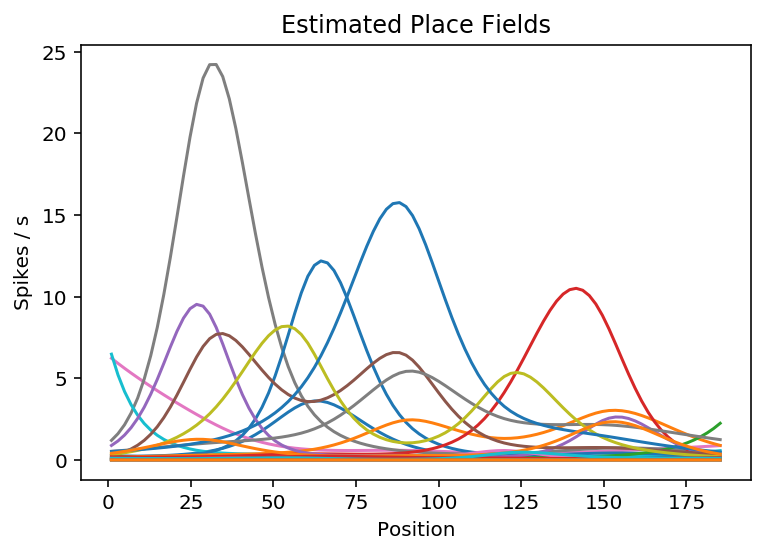

In [739]:
detector.plot_fitted_place_fields(sampling_frequency=SAMPLING_FREQUENCY)

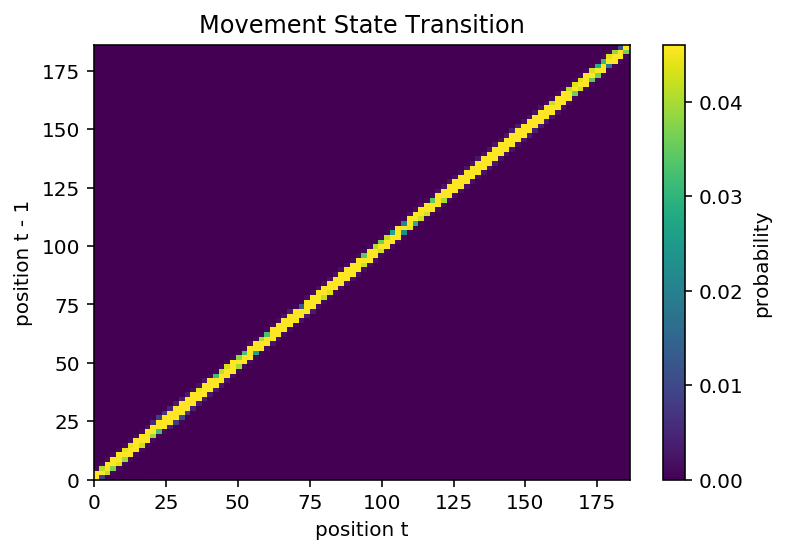

In [740]:
detector.plot_movement_state_transition()

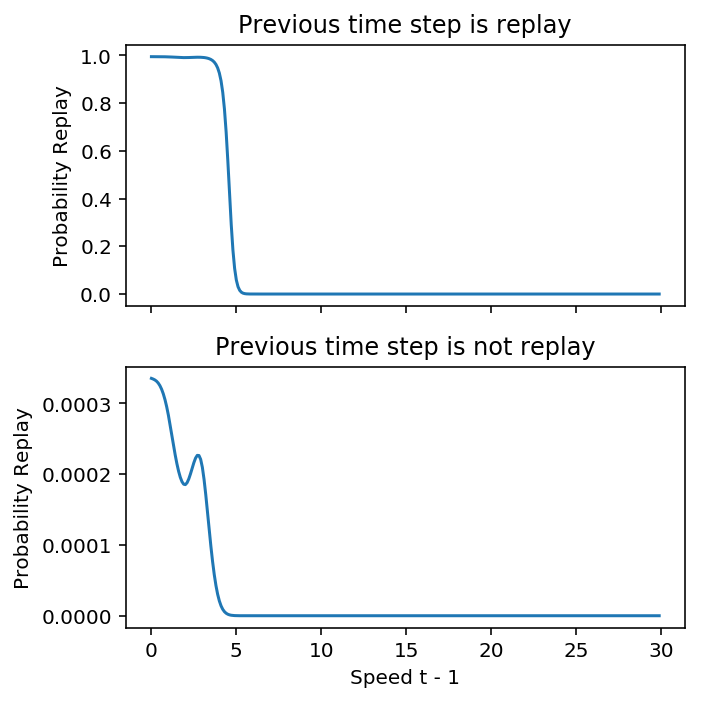

In [741]:
detector.plot_replay_state_transition()

## Spikes, LFPs, Speed

INFO:replay_identification.decoders:Predicting speed likelihood...
INFO:replay_identification.decoders:Predicting lfp_power likelihood...
INFO:replay_identification.decoders:Predicting spikes likelihood...
INFO:replay_identification.decoders:Predicting replay probability and density...


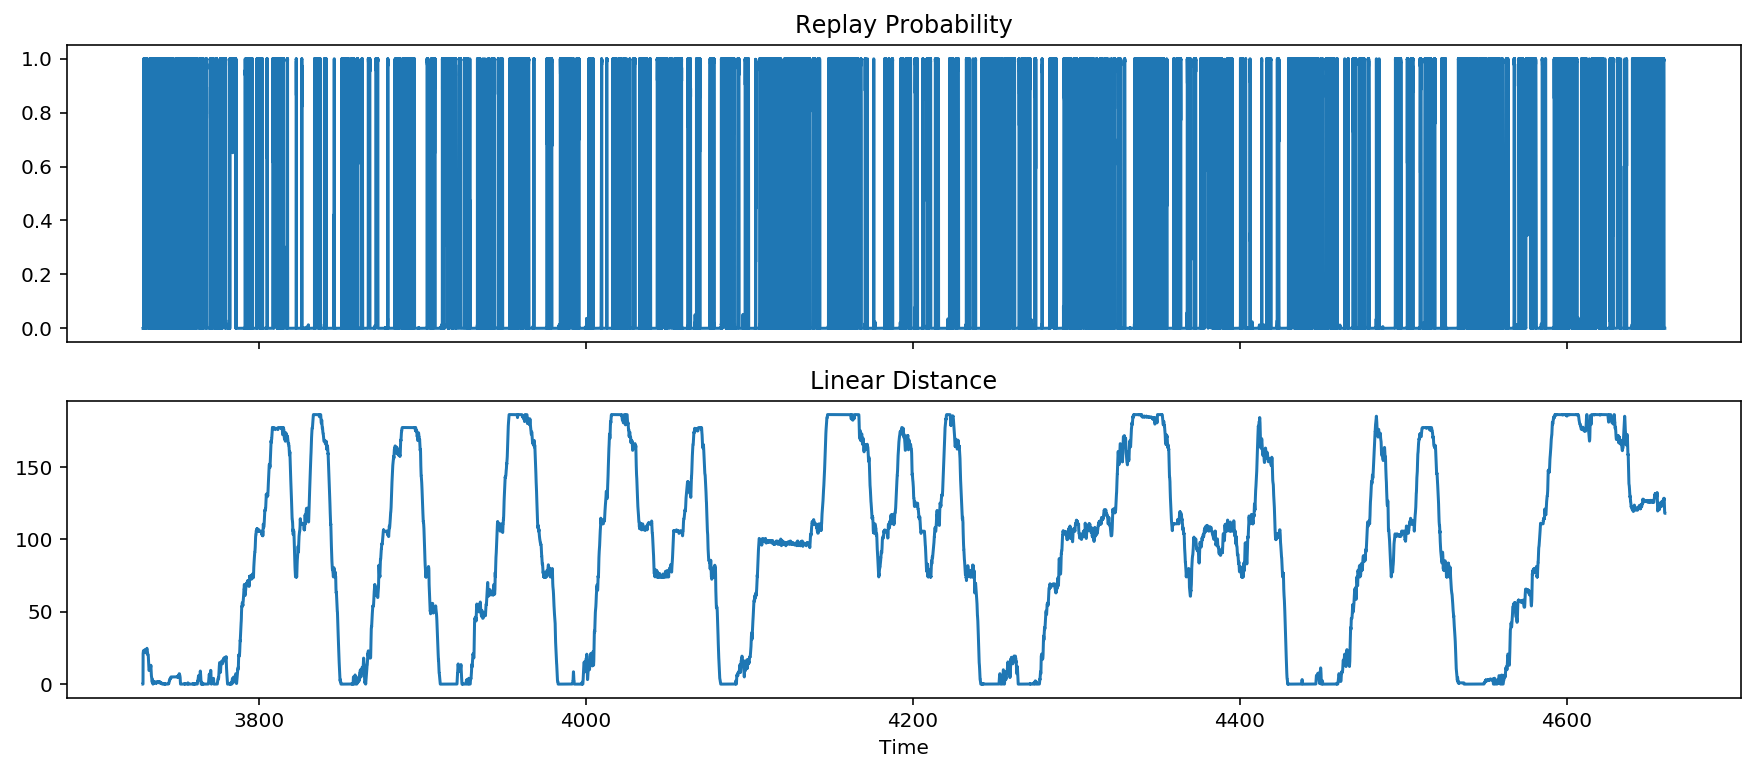

In [419]:
time = lfps.index.total_seconds().values

results = detector.predict(
    speed, power, linear_distance, spikes, time=time)

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(15, 6))
axes[0].plot(results.time, results.replay_probability)
axes[0].set_title('Replay Probability')
axes[1].plot(time, linear_distance)
axes[1].set_title('Linear Distance')
axes[-1].set_xlabel('Time');

## Spikes and LFPs

INFO:replay_identification.decoders:Predicting lfp_power likelihood...
INFO:replay_identification.decoders:Predicting spikes likelihood...
INFO:replay_identification.decoders:Predicting replay probability and density...


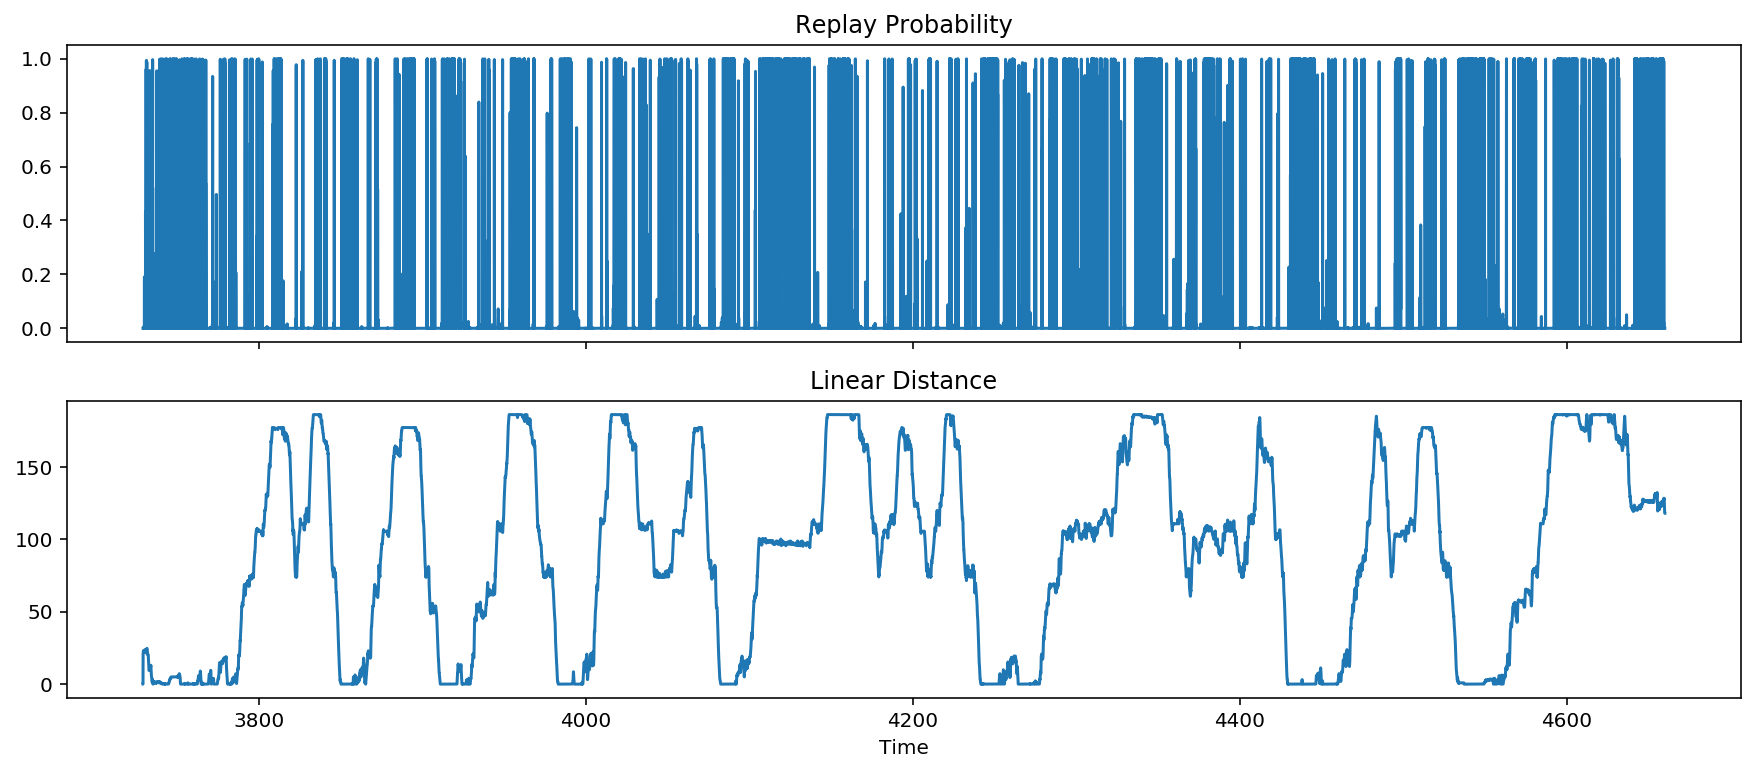

In [797]:
time = lfps.index.total_seconds().values

results = detector.predict(
    speed, power, linear_distance, spikes, time=time,
    use_likelihoods=['spikes', 'lfp_power'])

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(15, 6))
axes[0].plot(results.time, results.replay_probability)
axes[0].set_title('Replay Probability')
axes[1].plot(time, linear_distance)
axes[1].set_title('Linear Distance')
axes[-1].set_xlabel('Time');

## LFP Only

INFO:replay_identification.decoders:Predicting lfp_power likelihood...
INFO:replay_identification.decoders:Predicting replay probability and density...


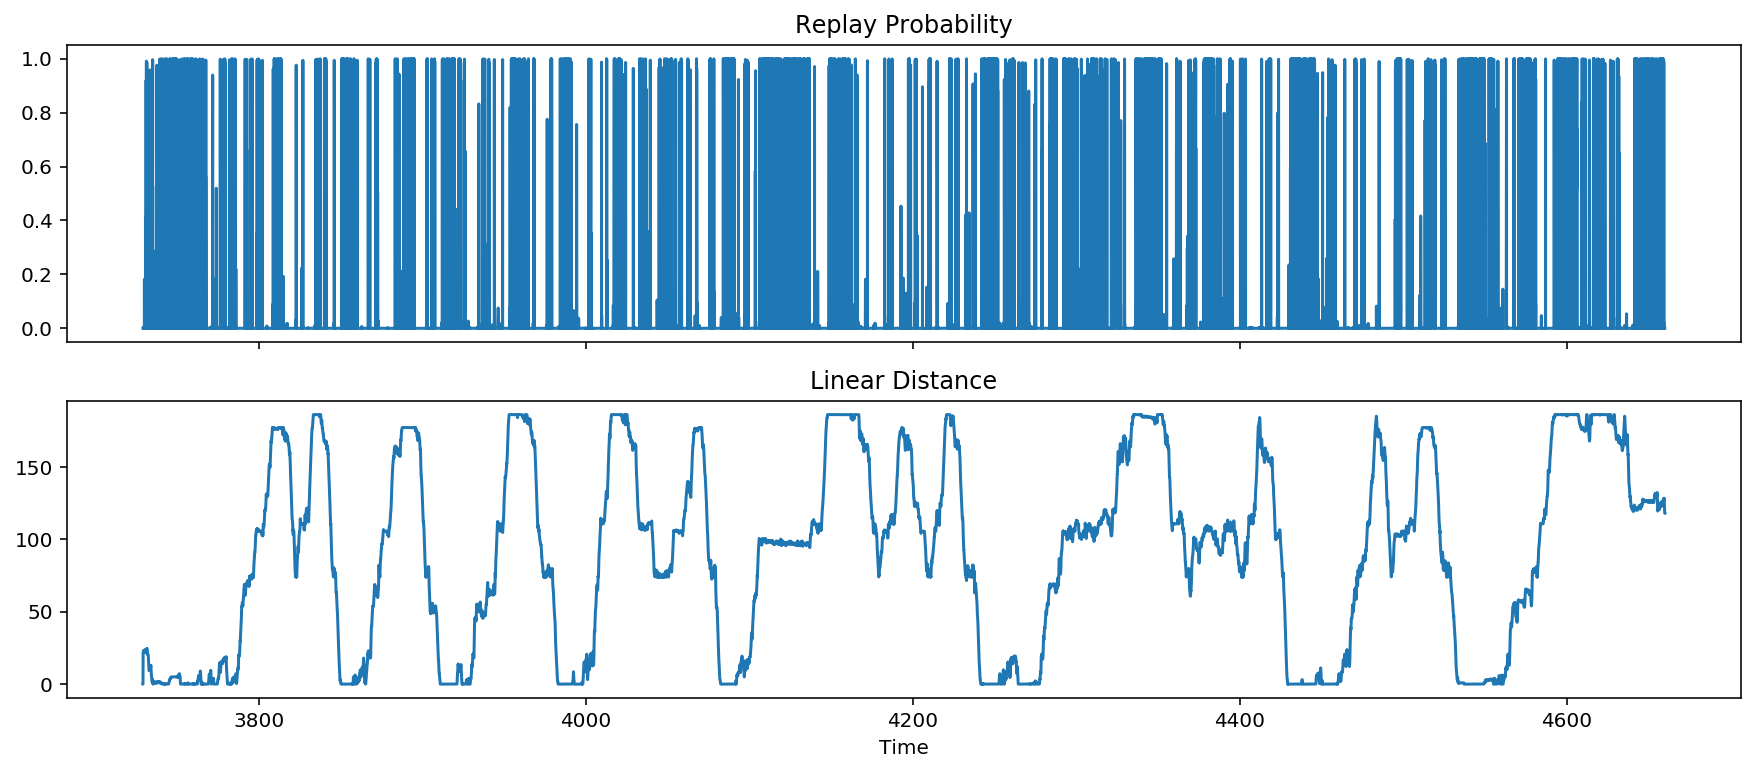

In [792]:
time = lfps.index.total_seconds().values

results = detector.predict(
    speed, power, linear_distance, spikes, time=time,
    use_likelihoods=['lfp_power'])

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(15, 6))
axes[0].plot(results.time, results.replay_probability)
axes[0].set_title('Replay Probability')
axes[1].plot(time, linear_distance)
axes[1].set_title('Linear Distance')
axes[-1].set_xlabel('Time');

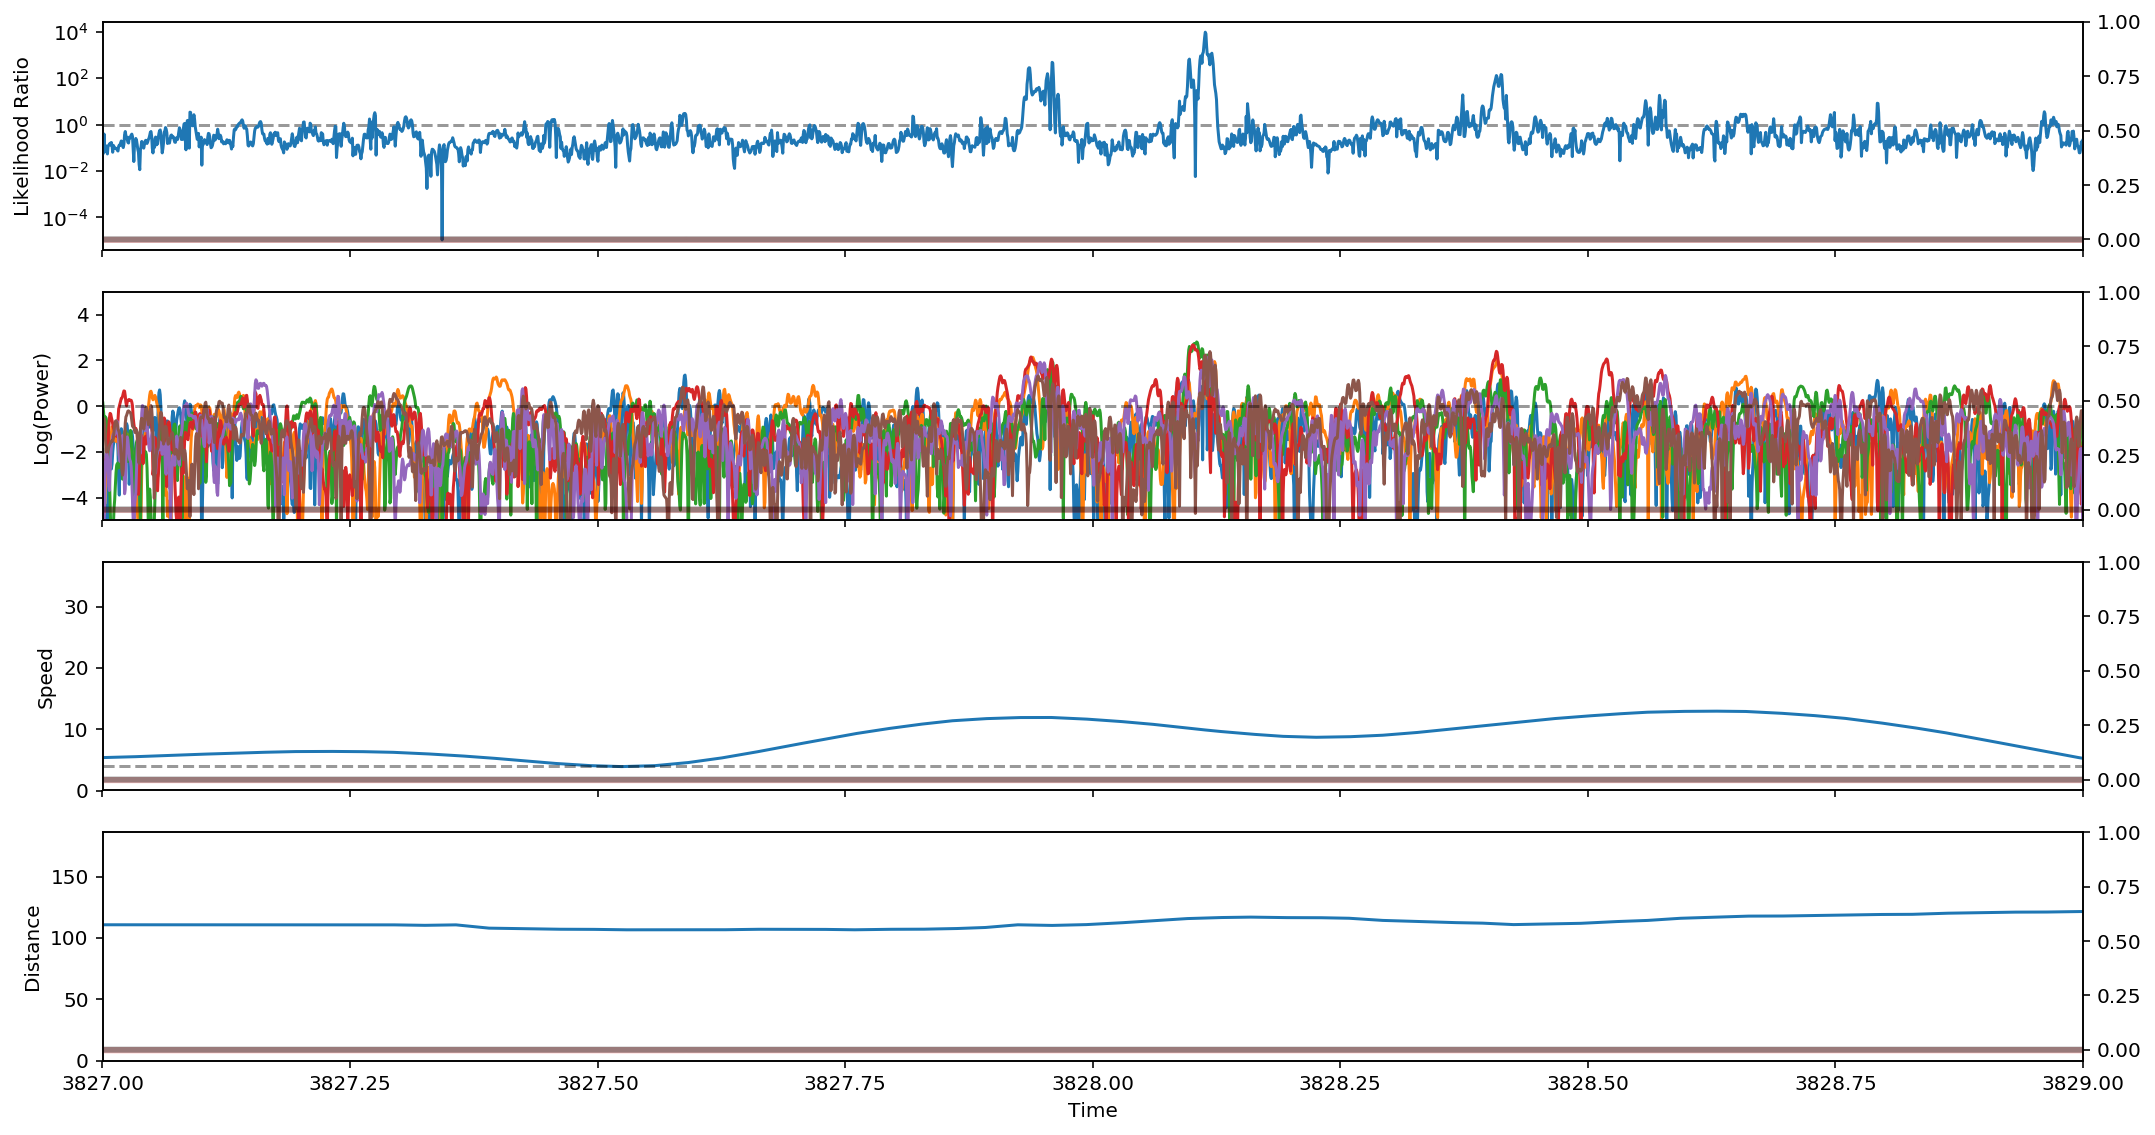

In [793]:
ind = (time > 3827) & (time < 3829)

fig, axes = plt.subplots(4, 1, figsize=(15, 8), sharex=True);
axes[0].semilogy(time[ind], results.likelihood[ind], zorder=100);
axes[0].axhline(1, linestyle='--', color='black', alpha=0.4);
axes[0].set_ylabel('Likelihood Ratio')

ax2=axes[0].twinx();
ax2.fill_between(time[ind], 0, results.replay_probability[ind],
         color='red', zorder=1, alpha=0.2, linewidth=3);
ax2.plot(time[ind], is_replay[ind], color='black', linewidth=3, alpha=0.4);
ax2.set_ylim((-0.05, 1))

axes[1].plot(time[ind], np.log(power)[ind]);
axes[1].axhline(0, color='black', alpha=0.4, linestyle='--');
axes[1].set_ylabel('Log(Power)')
axes[1].set_ylim((-5, 5))

ax2=axes[1].twinx();
ax2.fill_between(time[ind], 0, results.replay_probability[ind],
         color='red', zorder=1, alpha=0.2, linewidth=3);
ax2.plot(time[ind], is_replay[ind], color='black', linewidth=3, alpha=0.4);
ax2.set_ylim((-0.05, 1))

axes[2].plot(time[ind], speed[ind])
axes[2].axhline(4, linestyle='--', color='black', alpha=0.4)
axes[2].set_ylim((np.nanmin(speed), np.nanmax(speed)))
axes[2].set_ylabel('Speed')

ax2=axes[2].twinx();
ax2.fill_between(time[ind], 0, results.replay_probability[ind],
         color='red', zorder=1, alpha=0.2, linewidth=3);
ax2.plot(time[ind], is_replay[ind], color='black', linewidth=3, alpha=0.4);
ax2.set_ylim((-0.05, 1))

axes[3].plot(time[ind], linear_distance[ind])
axes[3].set_ylim((linear_distance.min(), linear_distance.max()))
axes[3].set_ylabel('Distance')

ax2=axes[3].twinx();
ax2.fill_between(time[ind], 0, results.replay_probability[ind],
         color='red', zorder=1, alpha=0.2, linewidth=3);
ax2.plot(time[ind], is_replay[ind], color='black', linewidth=3, alpha=0.4);
ax2.set_ylim((-0.05, 1))

axes[-1].set_xlabel('Time')

plt.xlim((time[ind].min(), time[ind].max()));

plt.tight_layout()

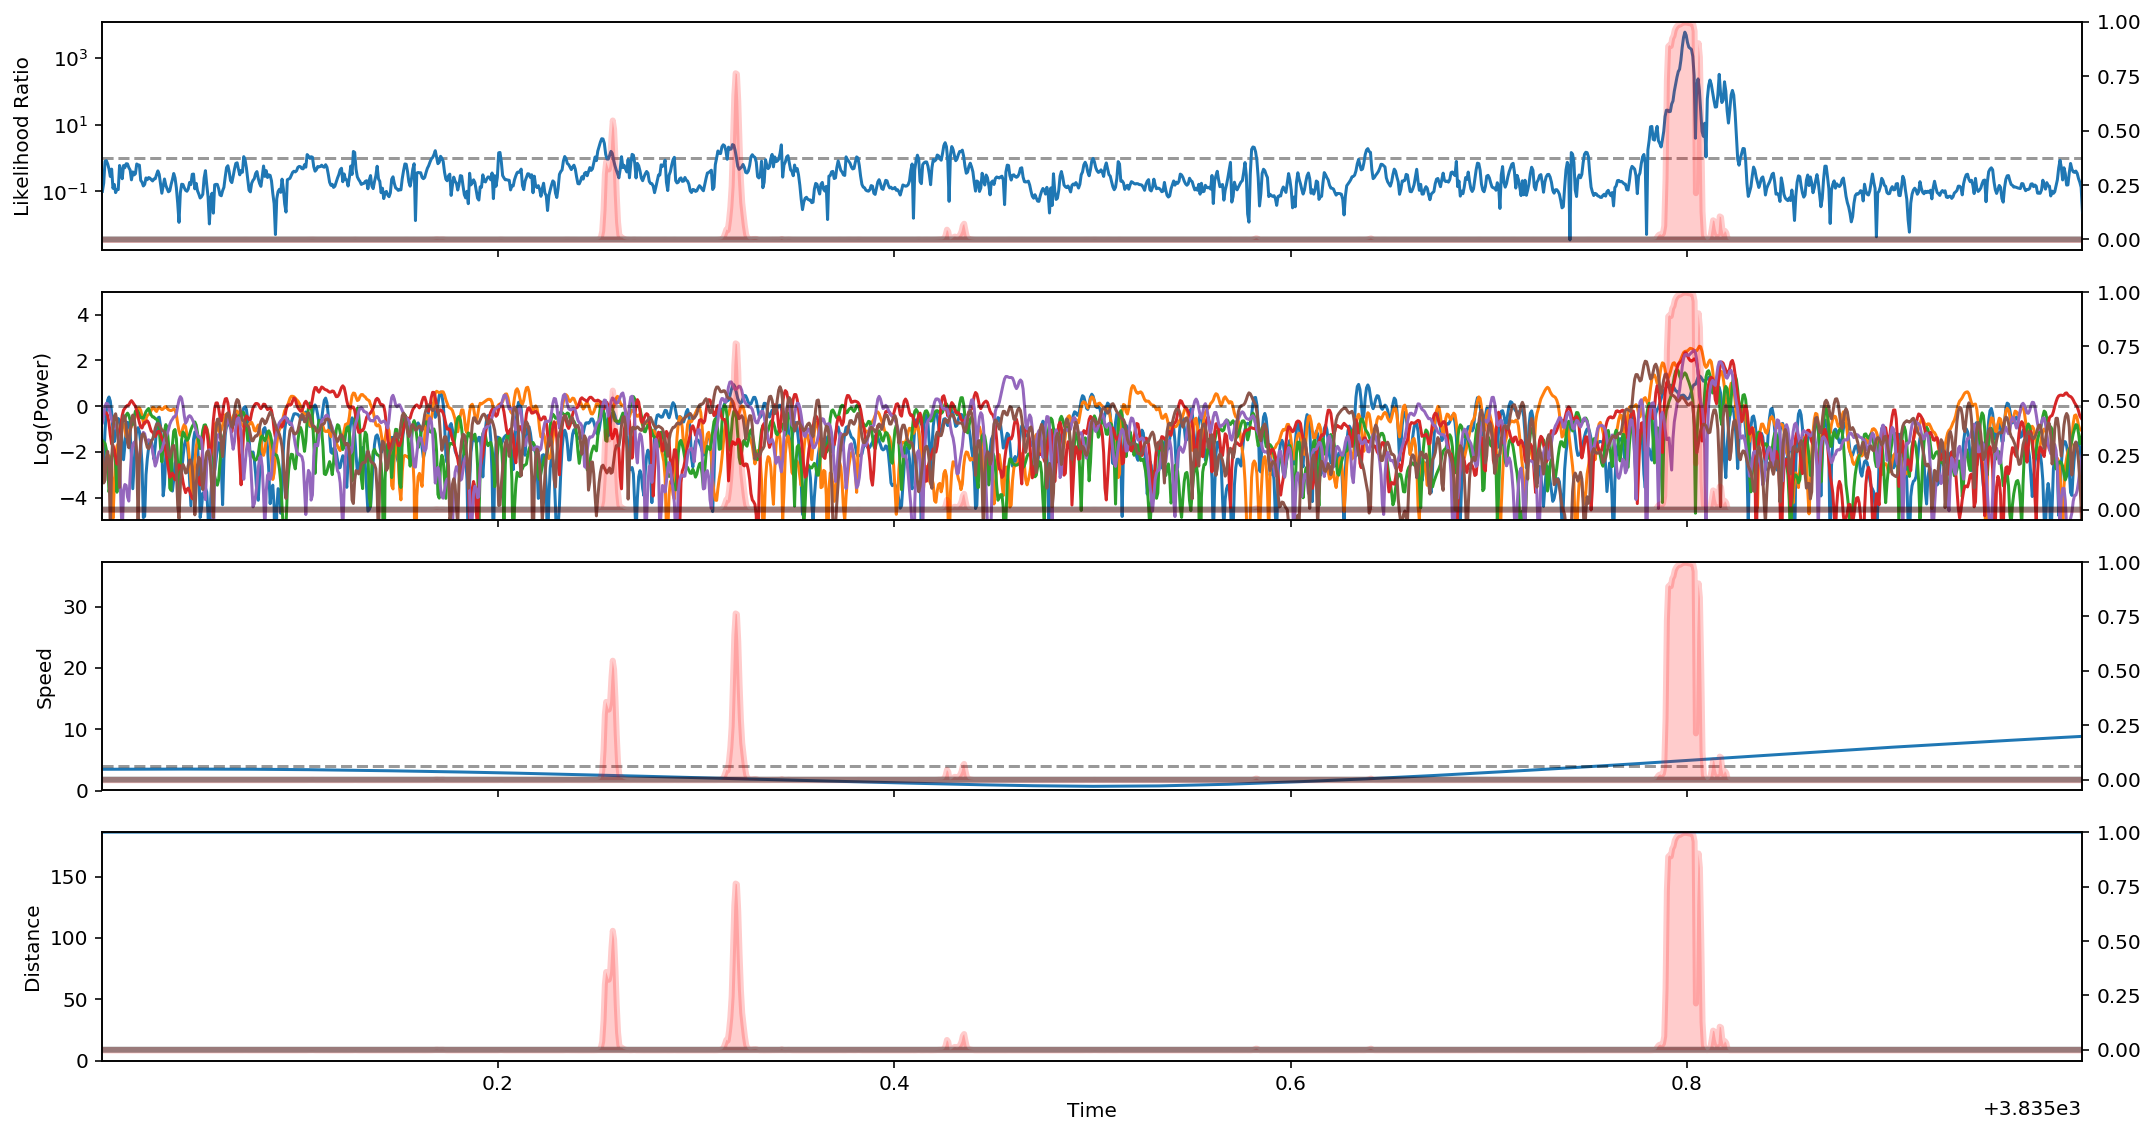

In [794]:
ind = (time > 3835) & (time < 3836)

fig, axes = plt.subplots(4, 1, figsize=(15, 8), sharex=True);
axes[0].semilogy(time[ind], results.likelihood[ind], zorder=100);
axes[0].axhline(1, linestyle='--', color='black', alpha=0.4);
axes[0].set_ylabel('Likelihood Ratio')

ax2=axes[0].twinx();
ax2.fill_between(time[ind], 0, results.replay_probability[ind],
         color='red', zorder=1, alpha=0.2, linewidth=3);
ax2.plot(time[ind], is_replay[ind], color='black', linewidth=3, alpha=0.4);
ax2.set_ylim((-0.05, 1))

axes[1].plot(time[ind], np.log(power)[ind]);
axes[1].axhline(0, color='black', alpha=0.4, linestyle='--');
axes[1].set_ylabel('Log(Power)')
axes[1].set_ylim((-5, 5))

ax2=axes[1].twinx();
ax2.fill_between(time[ind], 0, results.replay_probability[ind],
         color='red', zorder=1, alpha=0.2, linewidth=3);
ax2.plot(time[ind], is_replay[ind], color='black', linewidth=3, alpha=0.4);
ax2.set_ylim((-0.05, 1))

axes[2].plot(time[ind], speed[ind])
axes[2].axhline(4, linestyle='--', color='black', alpha=0.4)
axes[2].set_ylim((np.nanmin(speed), np.nanmax(speed)))
axes[2].set_ylabel('Speed')

ax2=axes[2].twinx();
ax2.fill_between(time[ind], 0, results.replay_probability[ind],
         color='red', zorder=1, alpha=0.2, linewidth=3);
ax2.plot(time[ind], is_replay[ind], color='black', linewidth=3, alpha=0.4);
ax2.set_ylim((-0.05, 1))

axes[3].plot(time[ind], linear_distance[ind])
axes[3].set_ylim((linear_distance.min(), linear_distance.max()))
axes[3].set_ylabel('Distance')

ax2=axes[3].twinx();
ax2.fill_between(time[ind], 0, results.replay_probability[ind],
         color='red', zorder=1, alpha=0.2, linewidth=3);
ax2.plot(time[ind], is_replay[ind], color='black', linewidth=3, alpha=0.4);
ax2.set_ylim((-0.05, 1))

axes[-1].set_xlabel('Time')

plt.xlim((time[ind].min(), time[ind].max()));

plt.tight_layout()

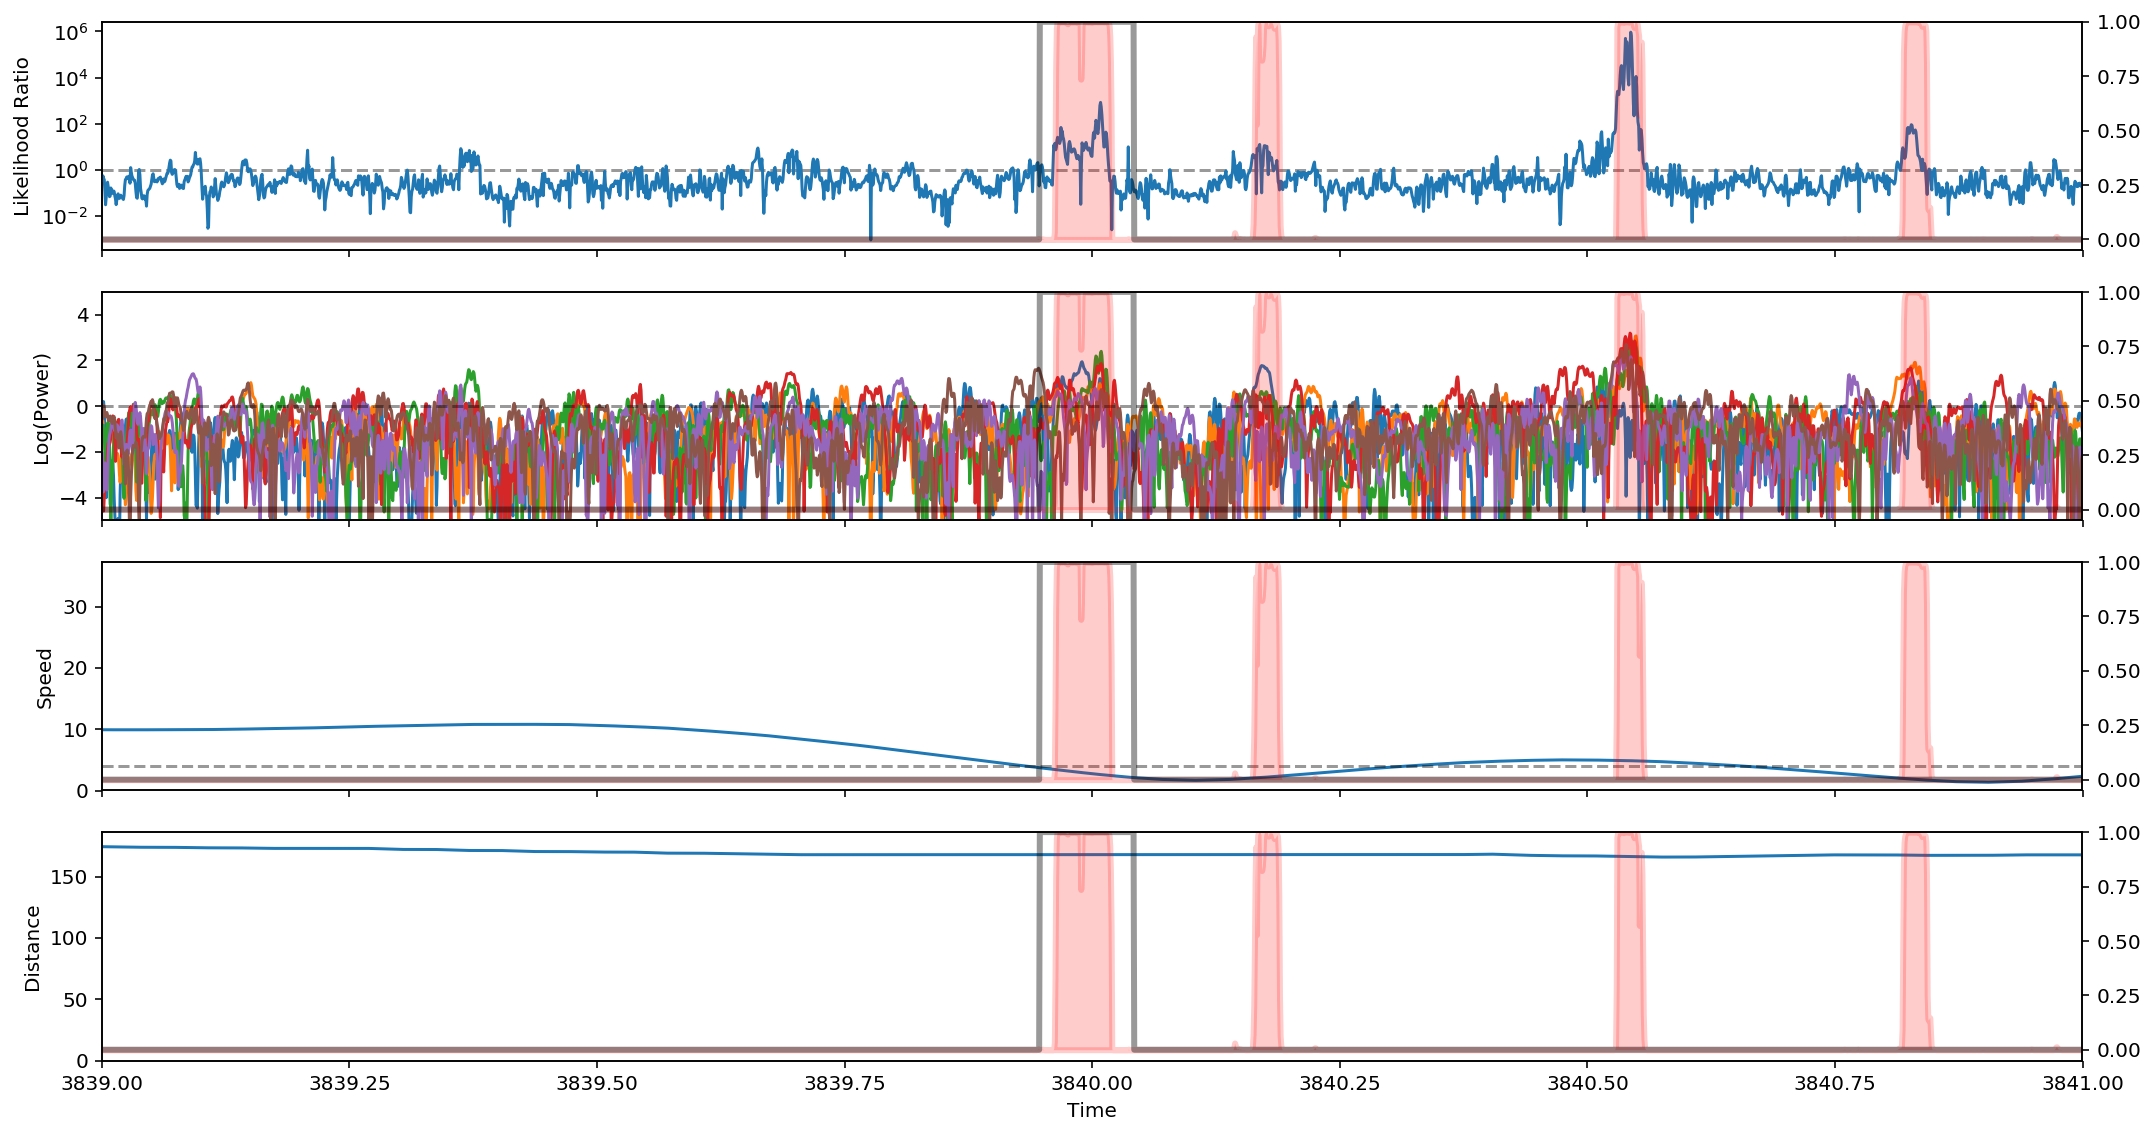

In [795]:
ind = (time > 3839) & (time < 3841)

fig, axes = plt.subplots(4, 1, figsize=(15, 8), sharex=True);
axes[0].semilogy(time[ind], results.likelihood[ind], zorder=100);
axes[0].axhline(1, linestyle='--', color='black', alpha=0.4);
axes[0].set_ylabel('Likelihood Ratio')

ax2=axes[0].twinx();
ax2.fill_between(time[ind], 0, results.replay_probability[ind],
         color='red', zorder=1, alpha=0.2, linewidth=3);
ax2.plot(time[ind], is_replay[ind], color='black', linewidth=3, alpha=0.4);
ax2.set_ylim((-0.05, 1))

axes[1].plot(time[ind], np.log(power)[ind]);
axes[1].axhline(0, color='black', alpha=0.4, linestyle='--');
axes[1].set_ylabel('Log(Power)')
axes[1].set_ylim((-5, 5))

ax2=axes[1].twinx();
ax2.fill_between(time[ind], 0, results.replay_probability[ind],
         color='red', zorder=1, alpha=0.2, linewidth=3);
ax2.plot(time[ind], is_replay[ind], color='black', linewidth=3, alpha=0.4);
ax2.set_ylim((-0.05, 1))

axes[2].plot(time[ind], speed[ind])
axes[2].axhline(4, linestyle='--', color='black', alpha=0.4)
axes[2].set_ylim((np.nanmin(speed), np.nanmax(speed)))
axes[2].set_ylabel('Speed')

ax2=axes[2].twinx();
ax2.fill_between(time[ind], 0, results.replay_probability[ind],
         color='red', zorder=1, alpha=0.2, linewidth=3);
ax2.plot(time[ind], is_replay[ind], color='black', linewidth=3, alpha=0.4);
ax2.set_ylim((-0.05, 1))

axes[3].plot(time[ind], linear_distance[ind])
axes[3].set_ylim((linear_distance.min(), linear_distance.max()))
axes[3].set_ylabel('Distance')

ax2=axes[3].twinx();
ax2.fill_between(time[ind], 0, results.replay_probability[ind],
         color='red', zorder=1, alpha=0.2, linewidth=3);
ax2.plot(time[ind], is_replay[ind], color='black', linewidth=3, alpha=0.4);
ax2.set_ylim((-0.05, 1))

axes[-1].set_xlabel('Time')

plt.xlim((time[ind].min(), time[ind].max()));

plt.tight_layout()

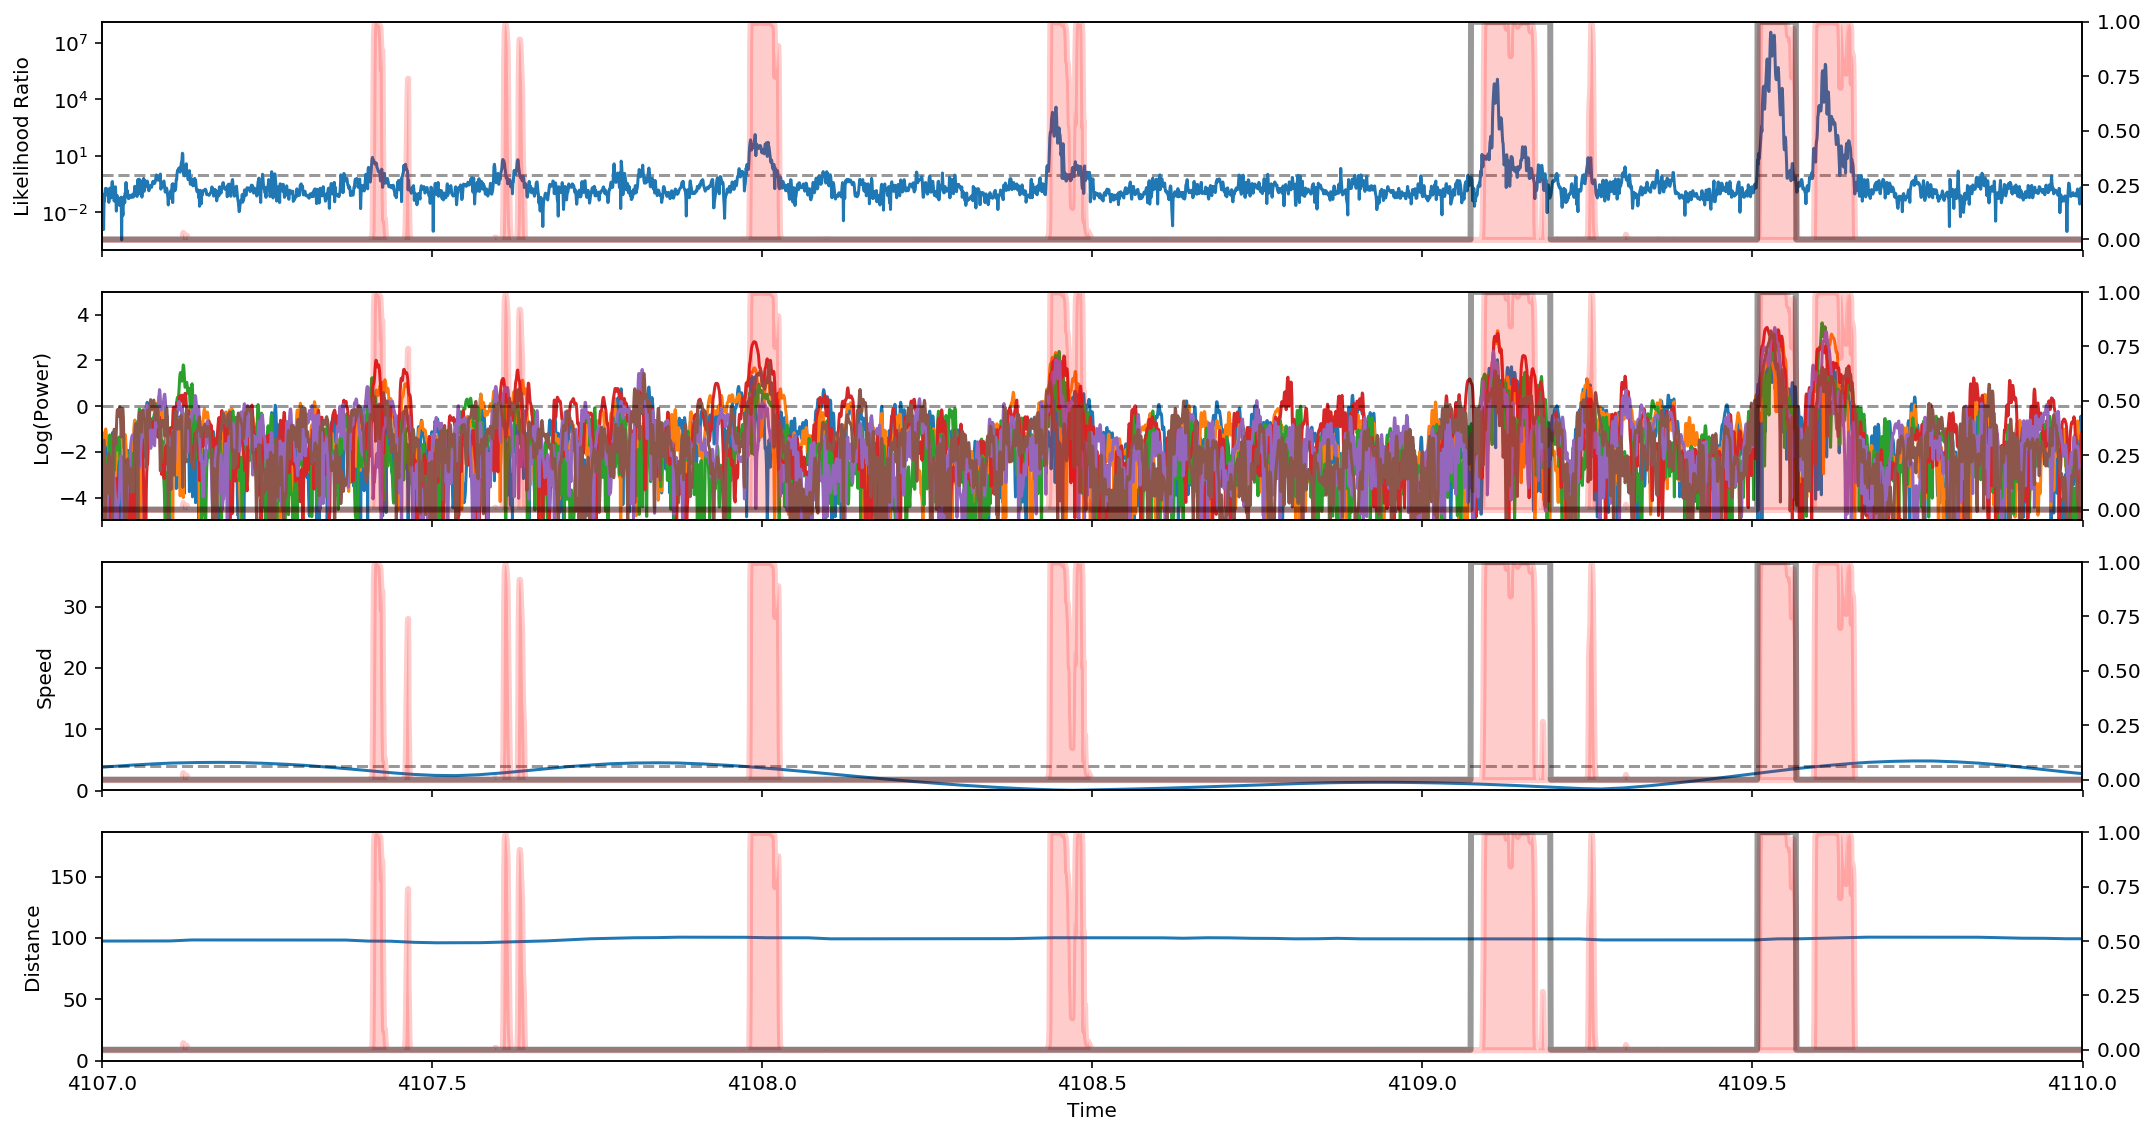

In [796]:
ind = (time > 4107) & (time < 4110)

fig, axes = plt.subplots(4, 1, figsize=(15, 8), sharex=True);
axes[0].semilogy(time[ind], results.likelihood[ind], zorder=100);
axes[0].axhline(1, linestyle='--', color='black', alpha=0.4);
axes[0].set_ylabel('Likelihood Ratio')

ax2=axes[0].twinx();
ax2.fill_between(time[ind], 0, results.replay_probability[ind],
         color='red', zorder=1, alpha=0.2, linewidth=3);
ax2.plot(time[ind], is_replay[ind], color='black', linewidth=3, alpha=0.4);
ax2.set_ylim((-0.05, 1))

axes[1].plot(time[ind], np.log(power)[ind]);
axes[1].axhline(0, color='black', alpha=0.4, linestyle='--');
axes[1].set_ylabel('Log(Power)')
axes[1].set_ylim((-5, 5))

ax2=axes[1].twinx();
ax2.fill_between(time[ind], 0, results.replay_probability[ind],
         color='red', zorder=1, alpha=0.2, linewidth=3);
ax2.plot(time[ind], is_replay[ind], color='black', linewidth=3, alpha=0.4);
ax2.set_ylim((-0.05, 1))

axes[2].plot(time[ind], speed[ind])
axes[2].axhline(4, linestyle='--', color='black', alpha=0.4)
axes[2].set_ylim((np.nanmin(speed), np.nanmax(speed)))
axes[2].set_ylabel('Speed')

ax2=axes[2].twinx();
ax2.fill_between(time[ind], 0, results.replay_probability[ind],
         color='red', zorder=1, alpha=0.2, linewidth=3);
ax2.plot(time[ind], is_replay[ind], color='black', linewidth=3, alpha=0.4);
ax2.set_ylim((-0.05, 1))

axes[3].plot(time[ind], linear_distance[ind])
axes[3].set_ylim((linear_distance.min(), linear_distance.max()))
axes[3].set_ylabel('Distance')

ax2=axes[3].twinx();
ax2.fill_between(time[ind], 0, results.replay_probability[ind],
         color='red', zorder=1, alpha=0.2, linewidth=3);
ax2.plot(time[ind], is_replay[ind], color='black', linewidth=3, alpha=0.4);
ax2.set_ylim((-0.05, 1))

axes[-1].set_xlabel('Time')

plt.xlim((time[ind].min(), time[ind].max()));

plt.tight_layout()

## Spikes Only

INFO:replay_identification.decoders:Predicting spikes likelihood...
INFO:replay_identification.decoders:Predicting replay probability and density...


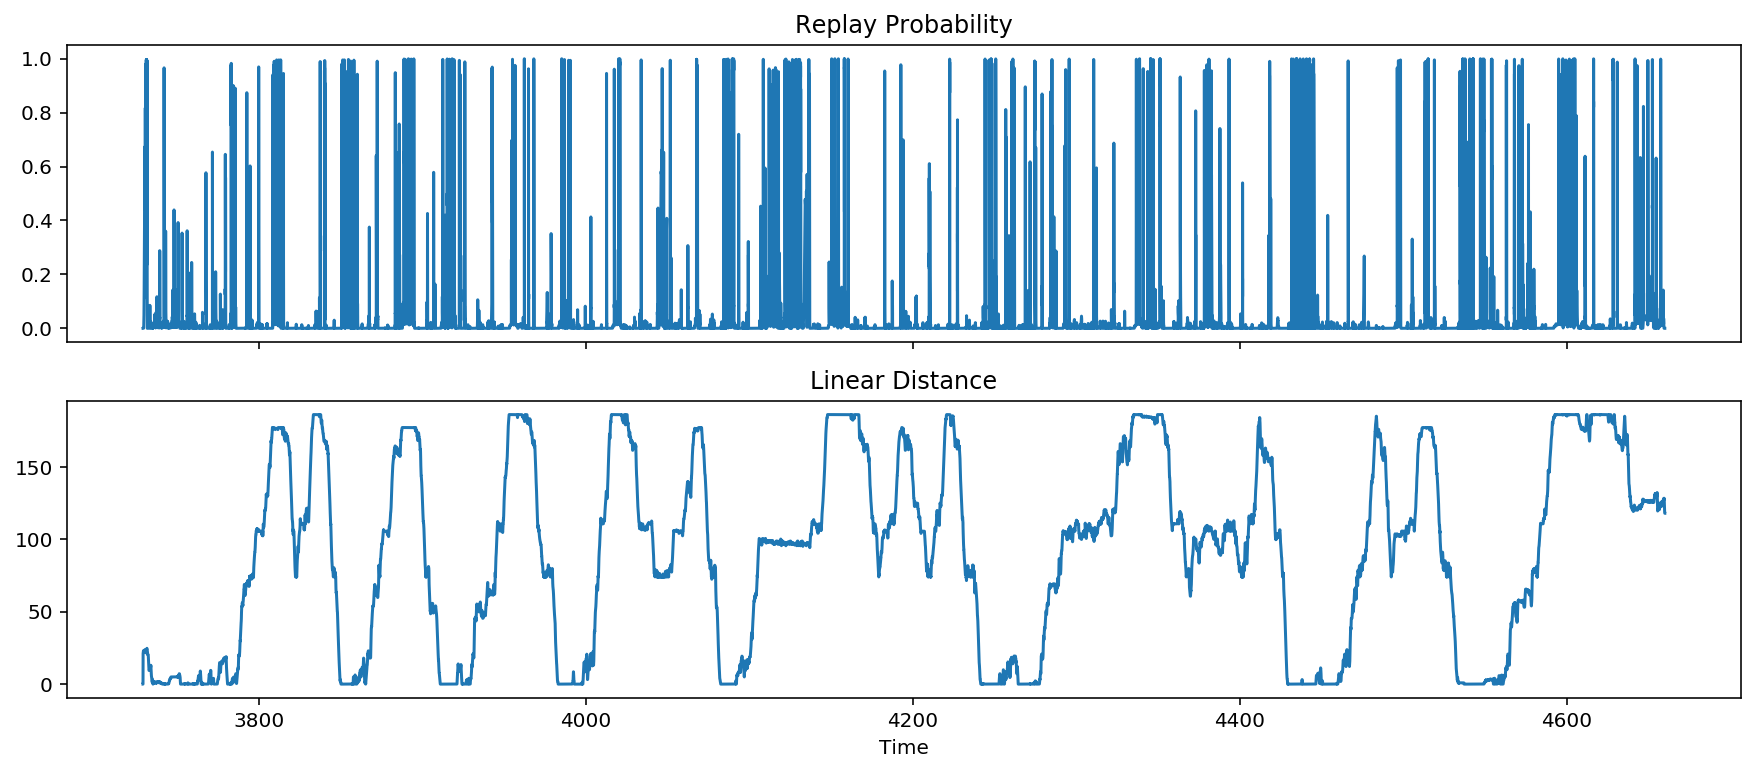

In [798]:
time = lfps.index.total_seconds().values

results = detector.predict(
    speed, power, linear_distance, spikes, time=time,
    use_likelihoods=['spikes'])

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(15, 6))
axes[0].plot(results.time, results.replay_probability)
axes[0].set_title('Replay Probability')
axes[1].plot(time, linear_distance)
axes[1].set_title('Linear Distance')
axes[-1].set_xlabel('Time');

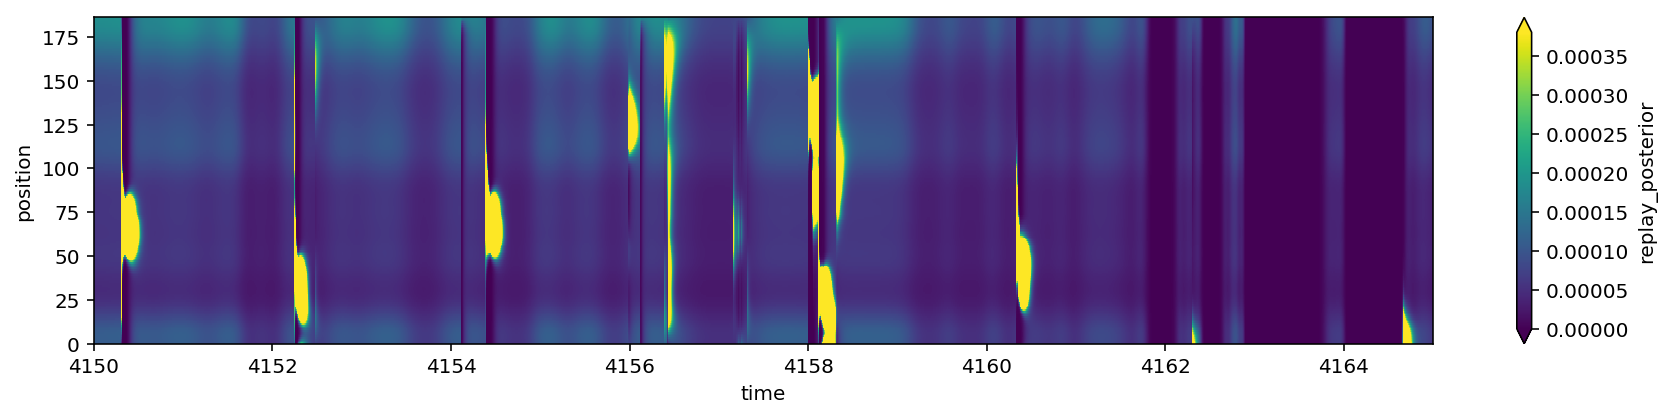

In [800]:
plt.figure(figsize=(15, 3))
results.sel(time=slice(4150, 4165)).replay_posterior.plot(x='time', y='position', robust=True)

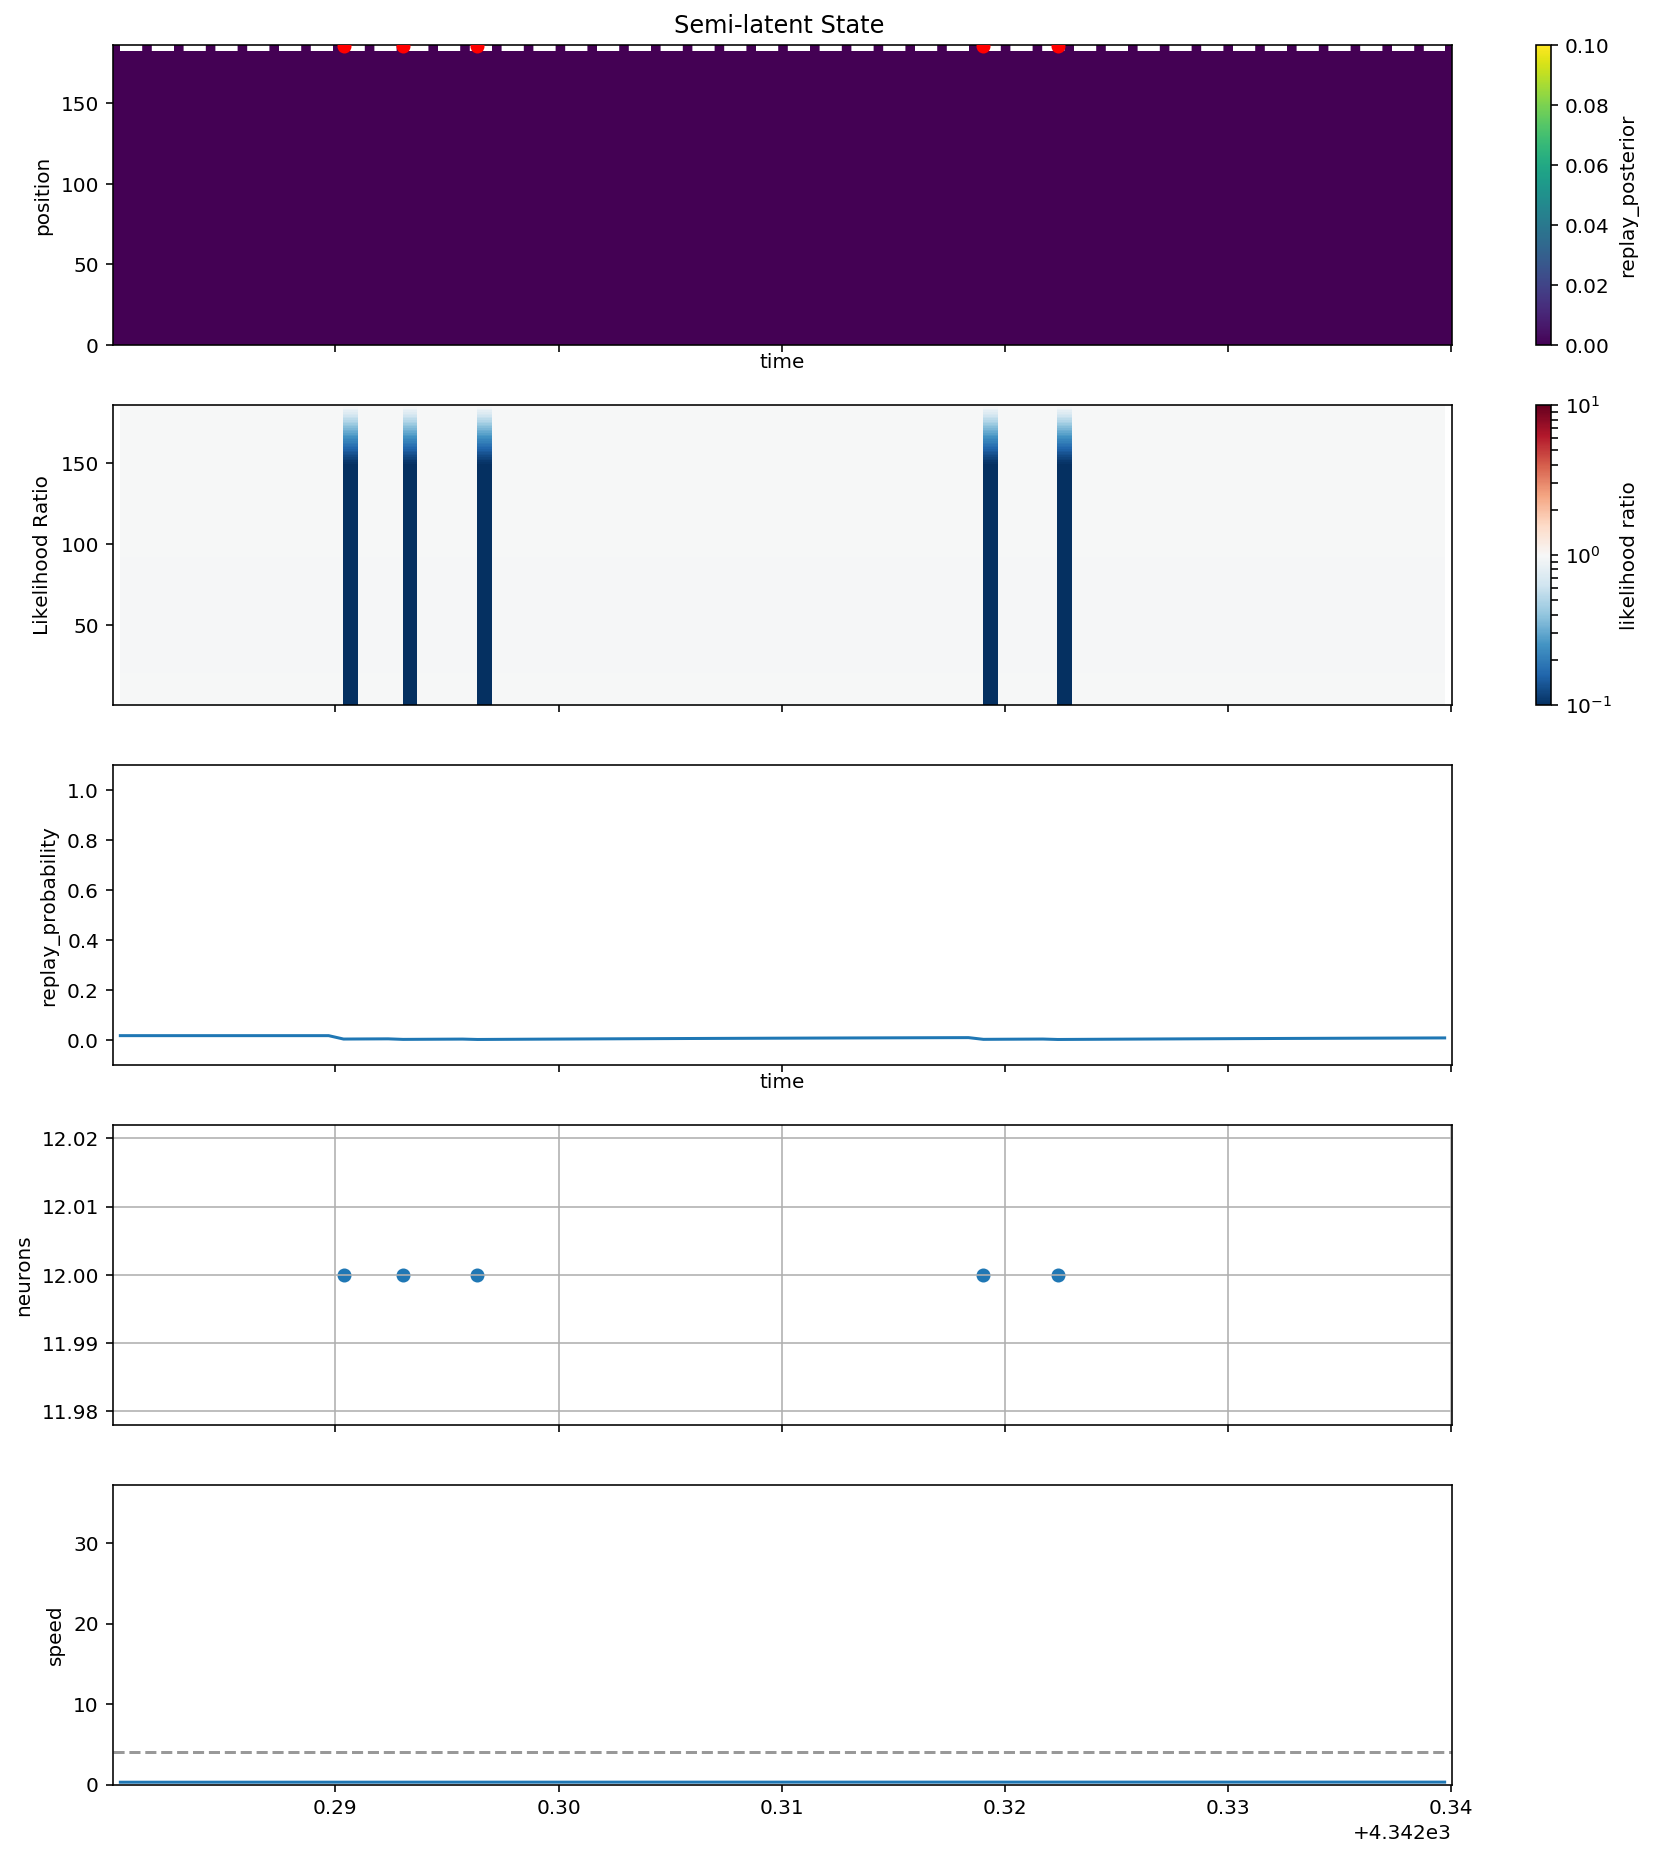

In [789]:
min_time, max_time = 4342.28, 4342.34
ind = (time > min_time) & (time < max_time)


likelihood = results.likelihood.sel(time=slice(min_time, max_time))
place_conditional_intensity = (
    detector._spiking_likelihood_ratio
    .keywords['place_conditional_intensity']).squeeze()

import matplotlib.colors as colors
fig, axes = plt.subplots(5, 1, figsize=(15, 16), sharex=True)
results.replay_posterior.sel(time=slice(min_time, max_time)).plot(
        x='time', y='position', ax=axes[0], vmin=0, vmax=0.1)
axes[0].set_title('Semi-latent State ')
axes[0].plot(time[ind], linear_distance[ind],
             color='white', linestyle='--', linewidth=3)
time_ind, neuron_ind = np.nonzero(spikes[ind])
axes[0].scatter(time[ind][time_ind],
            detector.place_bin_centers[np.argmax(place_conditional_intensity, axis=0)][neuron_ind],
               color='red', zorder=100)


t, p = likelihood.time, likelihood.position
t, p = np.meshgrid(t, p)
cax = axes[1].pcolormesh(
    t, p, likelihood.values.T,
    norm=colors.LogNorm(1E-1, 1E1), cmap='RdBu_r')
axes[1].set_ylabel('Likelihood Ratio')
plt.colorbar(cax, ax=axes[1], label='likelihood ratio', orientation='vertical')

sm = plt.cm.ScalarMappable()
sm.set_array([])

results.sel(time=slice(min_time, max_time)).replay_probability.plot(ax=axes[2])
axes[2].set_ylim((-0.1, 1.1))
plt.colorbar(sm, ax=axes[2]).ax.set_visible(False)
plt.colorbar(sm, ax=axes[3]).ax.set_visible(False)
plt.colorbar(sm, ax=axes[4]).ax.set_visible(False)

time_ind, neuron_ind = np.nonzero(spikes[ind])
axes[3].scatter(time[ind][time_ind], neuron_ind)
axes[3].grid('on')
axes[3].set_ylabel('neurons')

axes[4].plot(time[ind], speed[ind])
axes[4].axhline(4, linestyle='--', alpha=0.4, color='black')
axes[4].set_ylim((0, np.nanmax(speed)))
axes[4].set_ylabel('speed');

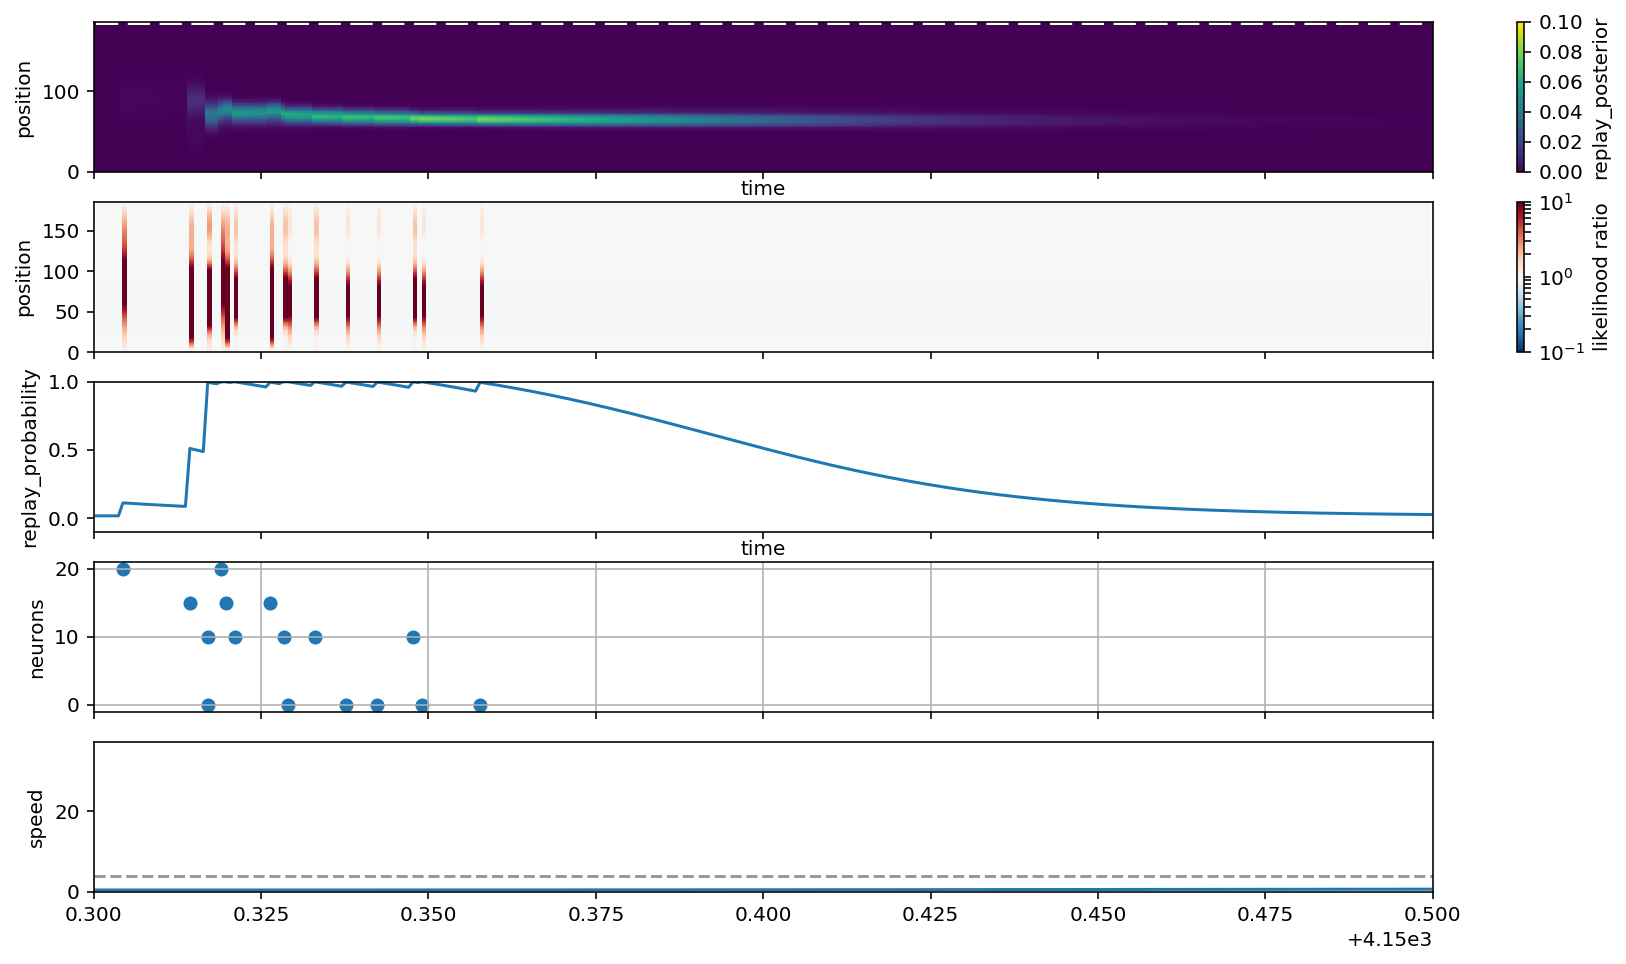

In [840]:
min_time, max_time = 4150.30, 4150.50
ind = (time > min_time) & (time < max_time)


fig, axes = plt.subplots(5, 1, figsize=(15, 8), sharex=True)
results.replay_posterior.sel(time=slice(min_time, max_time)).plot(
        x='time', y='position', ax=axes[0], vmin=0, vmax=0.1)
axes[0].plot(time[ind], linear_distance[ind],
             color='white', linestyle='--', linewidth=3)

likelihood = results.likelihood.sel(time=slice(min_time, max_time))
t, p = likelihood.time, likelihood.position
t, p = np.meshgrid(t, p)
cax = axes[1].pcolormesh(
    t, p, likelihood.values.T,
    norm=colors.LogNorm(1E-1, 1E1), cmap='RdBu_r')
axes[1].set_ylabel('position')
plt.colorbar(cax, ax=axes[1], label='likelihood ratio', orientation='vertical')

sm = plt.cm.ScalarMappable()
sm.set_array([])

results.sel(time=slice(min_time, max_time)).replay_probability.plot(ax=axes[2])
axes[2].set_ylim((-0.1, 1))
plt.colorbar(sm, ax=axes[2]).ax.set_visible(False)
plt.colorbar(sm, ax=axes[3]).ax.set_visible(False)
plt.colorbar(sm, ax=axes[4]).ax.set_visible(False)

time_ind, neuron_ind = np.nonzero(spikes[ind])
axes[3].scatter(time[ind][time_ind], neuron_ind)
axes[3].grid('on')
axes[3].set_ylabel('neurons')

axes[4].plot(time[ind], speed[ind])
axes[4].axhline(4, linestyle='--', alpha=0.4, color='black')
axes[4].set_ylim((0, np.nanmax(speed)))
axes[4].set_ylabel('speed');

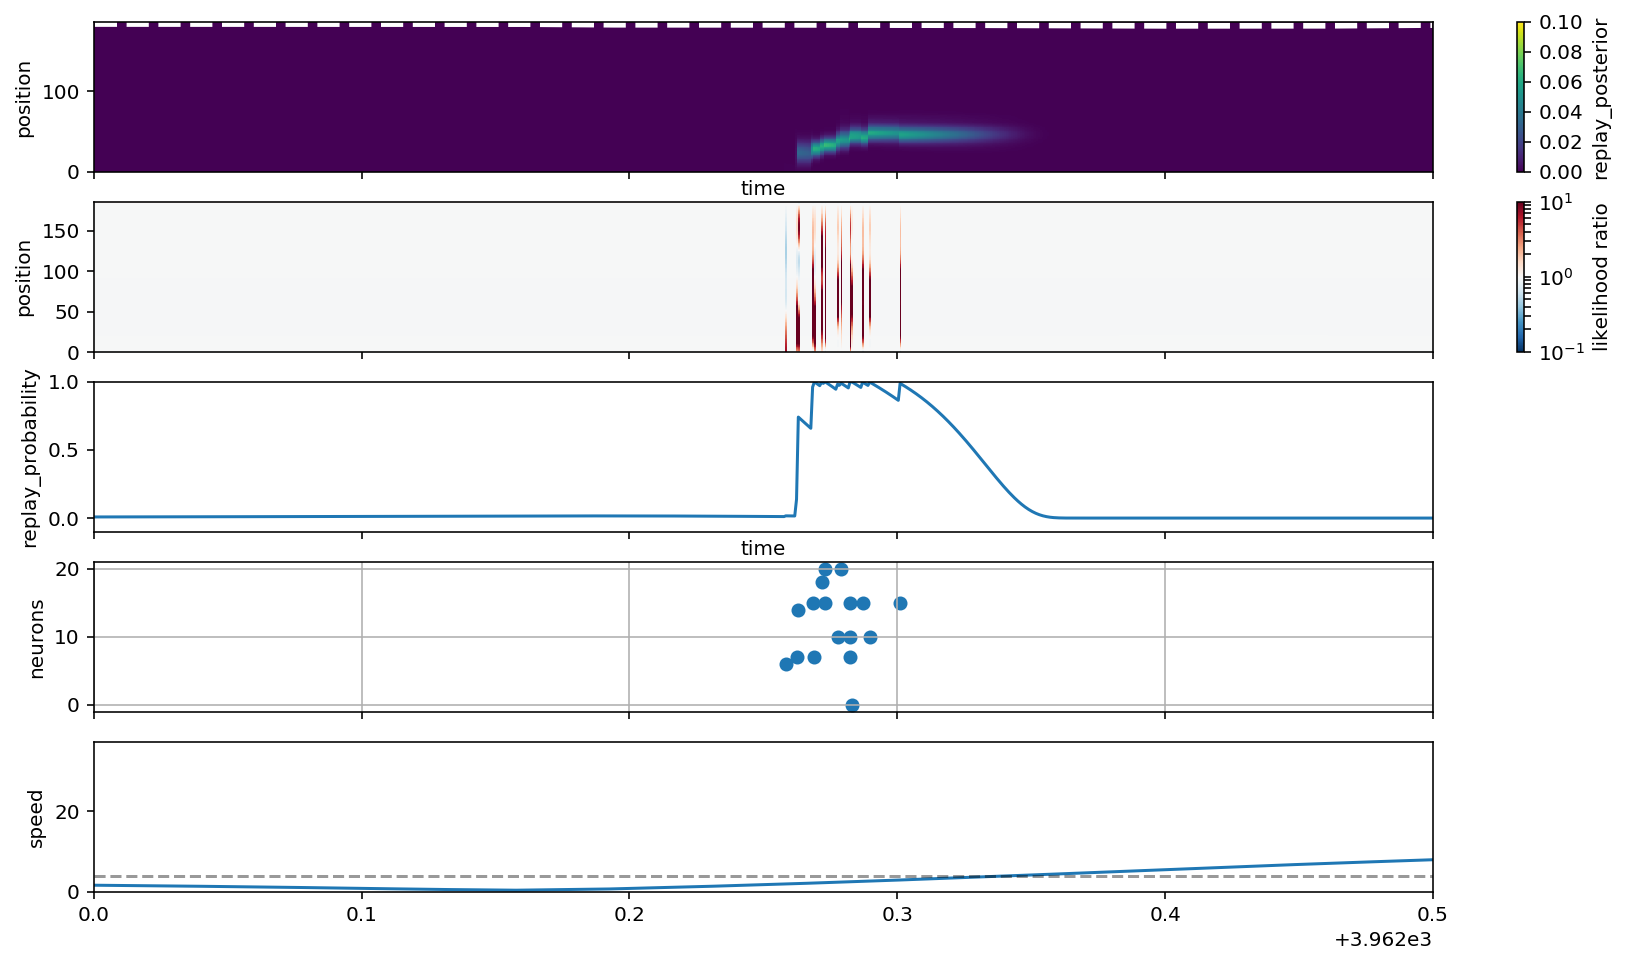

In [839]:
min_time, max_time = 3962, 3962.5
ind = (time > min_time) & (time < max_time)

fig, axes = plt.subplots(5, 1, figsize=(15, 8), sharex=True)
results.replay_posterior.sel(time=slice(min_time, max_time)).plot(
        x='time', y='position', ax=axes[0], vmin=0, vmax=0.1)
axes[0].plot(time[ind], linear_distance[ind],
             color='white', linestyle='--', linewidth=3)

likelihood = results.likelihood.sel(time=slice(min_time, max_time))
t, p = likelihood.time, likelihood.position
t, p = np.meshgrid(t, p)
cax = axes[1].pcolormesh(
    t, p, likelihood.values.T,
    norm=colors.LogNorm(1E-1, 1E1), cmap='RdBu_r')
axes[1].set_ylabel('position')
plt.colorbar(cax, ax=axes[1], label='likelihood ratio', orientation='vertical')

sm = plt.cm.ScalarMappable()
sm.set_array([])

results.sel(time=slice(min_time, max_time)).replay_probability.plot(ax=axes[2])
axes[2].set_ylim((-0.1, 1))
plt.colorbar(sm, ax=axes[2]).ax.set_visible(False)
plt.colorbar(sm, ax=axes[3]).ax.set_visible(False)
plt.colorbar(sm, ax=axes[4]).ax.set_visible(False)

time_ind, neuron_ind = np.nonzero(spikes[ind])
axes[3].scatter(time[ind][time_ind], neuron_ind)
axes[3].grid('on')
axes[3].set_ylabel('neurons')

axes[4].plot(time[ind], speed[ind])
axes[4].axhline(4, linestyle='--', alpha=0.4, color='black')
axes[4].set_ylim((0, np.nanmax(speed)))
axes[4].set_ylabel('speed');

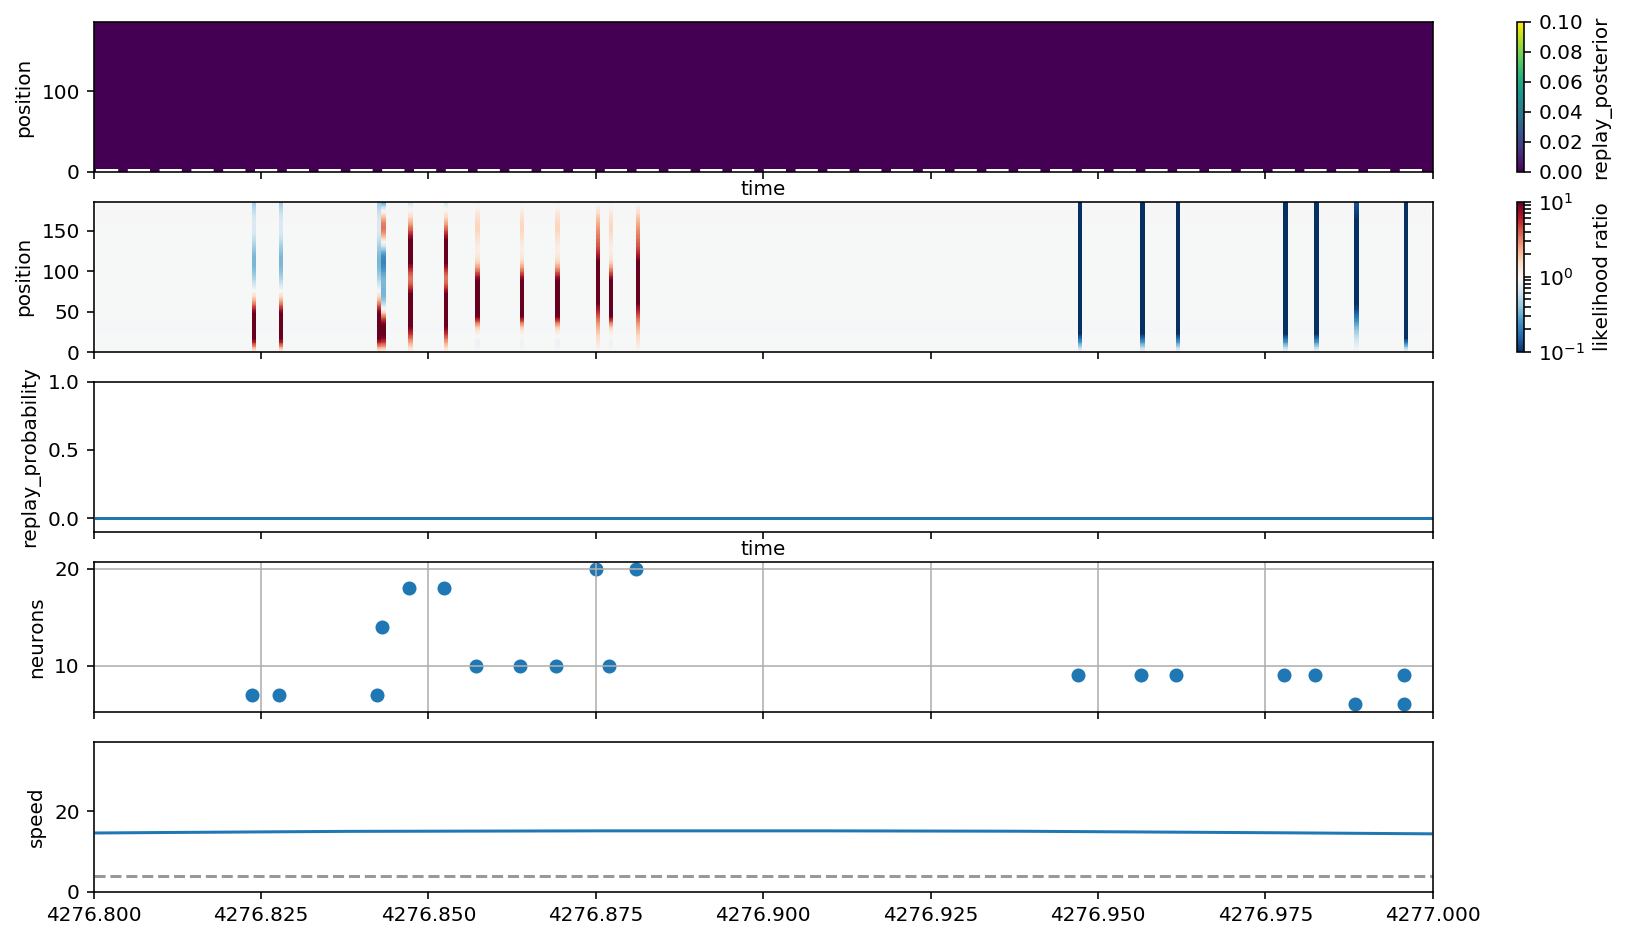

In [838]:
min_time, max_time = 4276.8, 4277
ind = (time > min_time) & (time < max_time)

import matplotlib.colors as colors
fig, axes = plt.subplots(5, 1, figsize=(15, 8), sharex=True)
results.replay_posterior.sel(time=slice(min_time, max_time)).plot(
        x='time', y='position', ax=axes[0], vmin=0, vmax=0.1)
axes[0].plot(time[ind], linear_distance[ind],
             color='white', linestyle='--', linewidth=3)

likelihood = results.likelihood.sel(time=slice(min_time, max_time))
t, p = likelihood.time, likelihood.position
t, p = np.meshgrid(t, p)
cax = axes[1].pcolormesh(
    t, p, likelihood.values.T,
    norm=colors.LogNorm(1E-1, 1E1), cmap='RdBu_r')
axes[1].set_ylabel('position')
plt.colorbar(cax, ax=axes[1], label='likelihood ratio', orientation='vertical')

sm = plt.cm.ScalarMappable()
sm.set_array([])

results.sel(time=slice(min_time, max_time)).replay_probability.plot(ax=axes[2])
axes[2].set_ylim((-0.1, 1))
plt.colorbar(sm, ax=axes[2]).ax.set_visible(False)
plt.colorbar(sm, ax=axes[3]).ax.set_visible(False)
plt.colorbar(sm, ax=axes[4]).ax.set_visible(False)

time_ind, neuron_ind = np.nonzero(spikes[ind])
axes[3].scatter(time[ind][time_ind], neuron_ind)
axes[3].grid('on')
axes[3].set_ylabel('neurons')

axes[4].plot(time[ind], speed[ind])
axes[4].axhline(4, linestyle='--', alpha=0.4, color='black')
axes[4].set_ylim((0, np.nanmax(speed)))
axes[4].set_ylabel('speed');

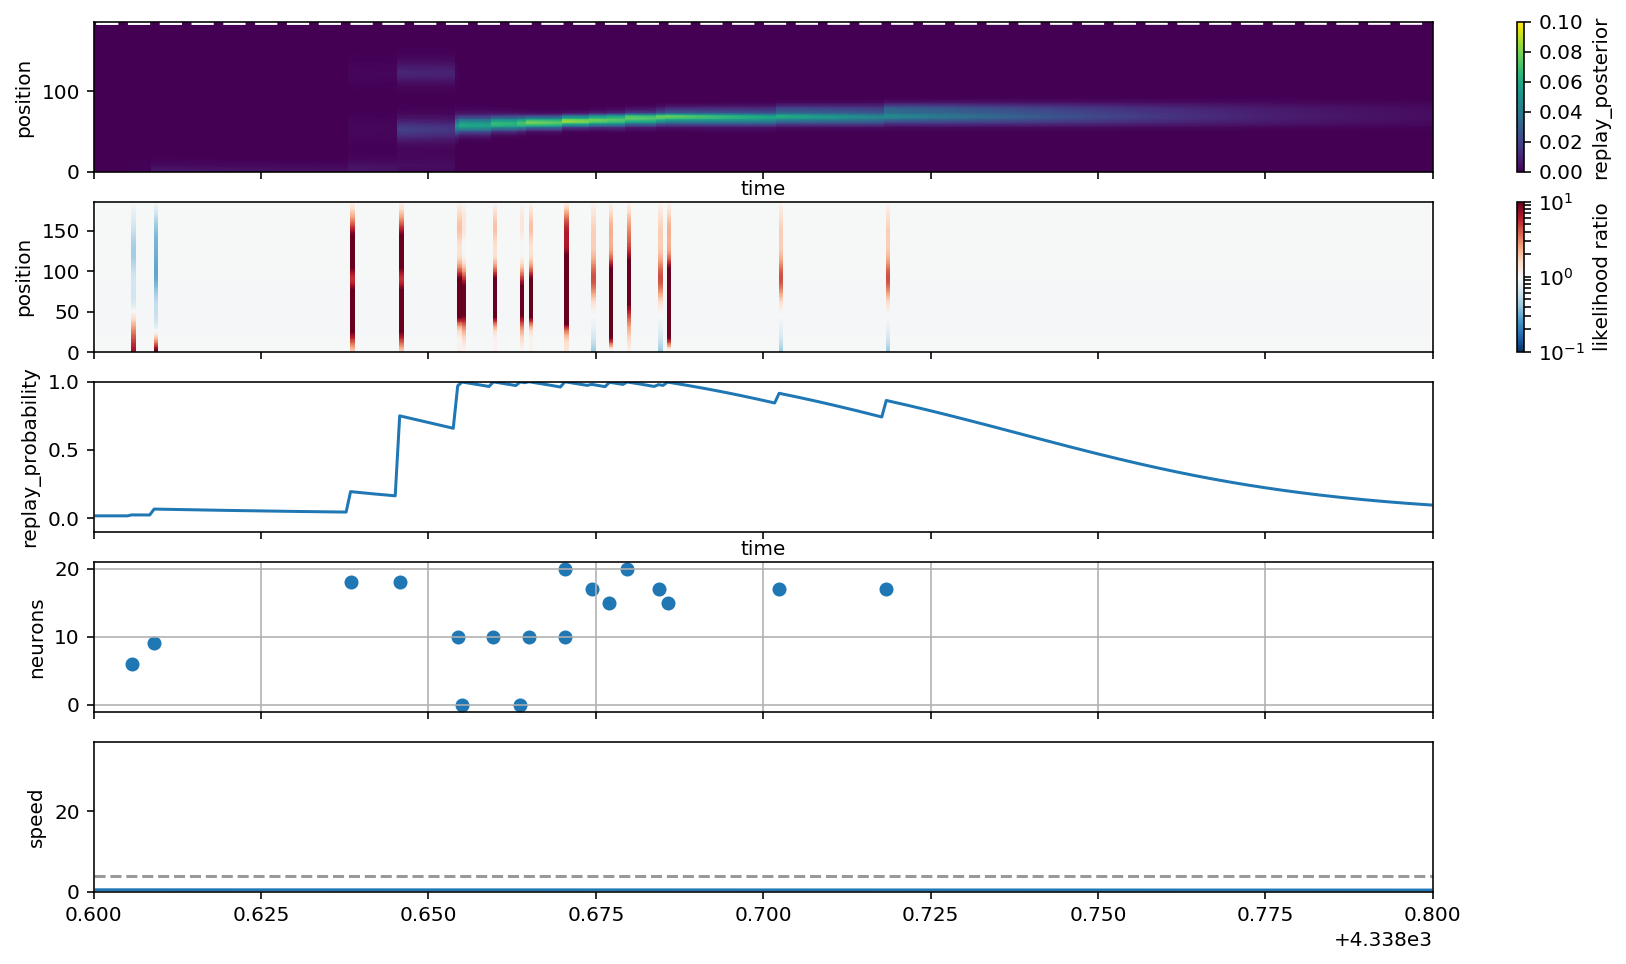

In [837]:
min_time, max_time = 4338.6, 4338.8
ind = (time > min_time) & (time < max_time)

fig, axes = plt.subplots(5, 1, figsize=(15, 8), sharex=True)
results.replay_posterior.sel(time=slice(min_time, max_time)).plot(
        x='time', y='position', ax=axes[0], vmin=0, vmax=0.1)
axes[0].plot(time[ind], linear_distance[ind],
             color='white', linestyle='--', linewidth=3)

likelihood = results.likelihood.sel(time=slice(min_time, max_time))
t, p = likelihood.time, likelihood.position
t, p = np.meshgrid(t, p)
cax = axes[1].pcolormesh(
    t, p, likelihood.values.T,
    norm=colors.LogNorm(1E-1, 1E1), cmap='RdBu_r')
axes[1].set_ylabel('position')
plt.colorbar(cax, ax=axes[1], label='likelihood ratio', orientation='vertical')

sm = plt.cm.ScalarMappable()
sm.set_array([])

results.sel(time=slice(min_time, max_time)).replay_probability.plot(ax=axes[2])
axes[2].set_ylim((-0.1, 1))
plt.colorbar(sm, ax=axes[2]).ax.set_visible(False)
plt.colorbar(sm, ax=axes[3]).ax.set_visible(False)
plt.colorbar(sm, ax=axes[4]).ax.set_visible(False)

time_ind, neuron_ind = np.nonzero(spikes[ind])
axes[3].scatter(time[ind][time_ind], neuron_ind)
axes[3].grid('on')
axes[3].set_ylabel('neurons')

axes[4].plot(time[ind], speed[ind])
axes[4].axhline(4, linestyle='--', alpha=0.4, color='black')
axes[4].set_ylim((0, np.nanmax(speed)))
axes[4].set_ylabel('speed');

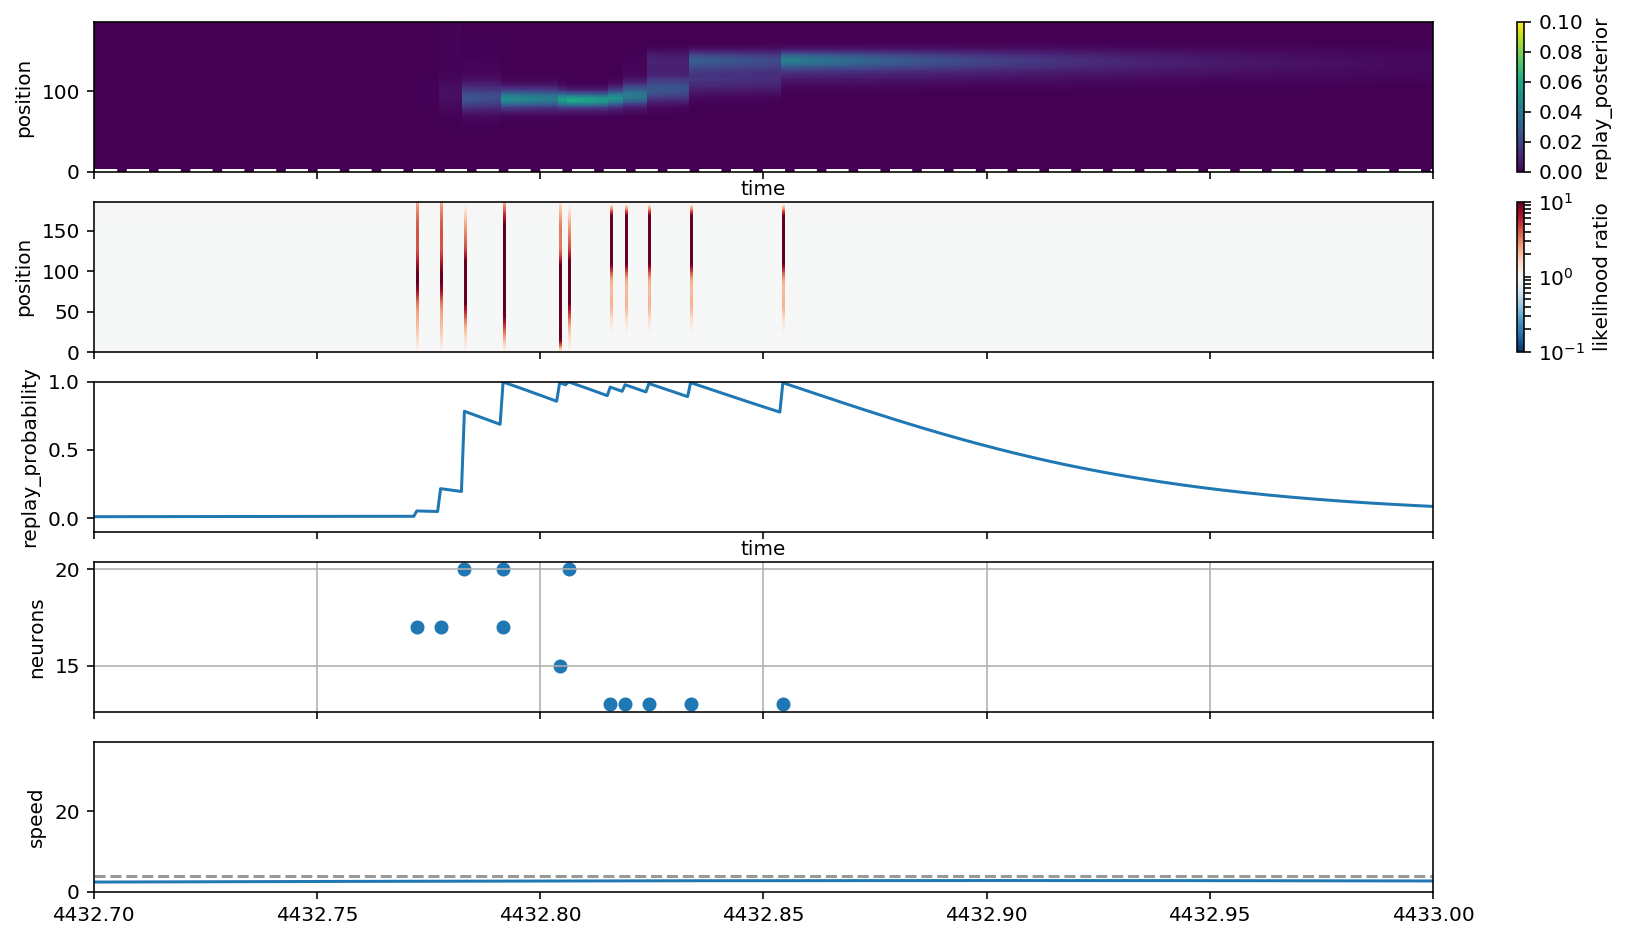

In [836]:
min_time, max_time = 4432.7, 4433
ind = (time > min_time) & (time < max_time)

fig, axes = plt.subplots(5, 1, figsize=(15, 8), sharex=True)
results.replay_posterior.sel(time=slice(min_time, max_time)).plot(
        x='time', y='position', ax=axes[0], vmin=0, vmax=0.1)
axes[0].plot(time[ind], linear_distance[ind],
             color='white', linestyle='--', linewidth=3)

likelihood = results.likelihood.sel(time=slice(min_time, max_time))
t, p = likelihood.time, likelihood.position
t, p = np.meshgrid(t, p)
cax = axes[1].pcolormesh(
    t, p, likelihood.values.T,
    norm=colors.LogNorm(1E-1, 1E1), cmap='RdBu_r')
axes[1].set_ylabel('position')
plt.colorbar(cax, ax=axes[1], label='likelihood ratio', orientation='vertical')

sm = plt.cm.ScalarMappable()
sm.set_array([])

results.sel(time=slice(min_time, max_time)).replay_probability.plot(ax=axes[2])
axes[2].set_ylim((-0.1, 1))
plt.colorbar(sm, ax=axes[2]).ax.set_visible(False)
plt.colorbar(sm, ax=axes[3]).ax.set_visible(False)
plt.colorbar(sm, ax=axes[4]).ax.set_visible(False)

time_ind, neuron_ind = np.nonzero(spikes[ind])
axes[3].scatter(time[ind][time_ind], neuron_ind)
axes[3].grid('on')
axes[3].set_ylabel('neurons')

axes[4].plot(time[ind], speed[ind])
axes[4].axhline(4, linestyle='--', alpha=0.4, color='black')
axes[4].set_ylim((0, np.nanmax(speed)))
axes[4].set_ylabel('speed');

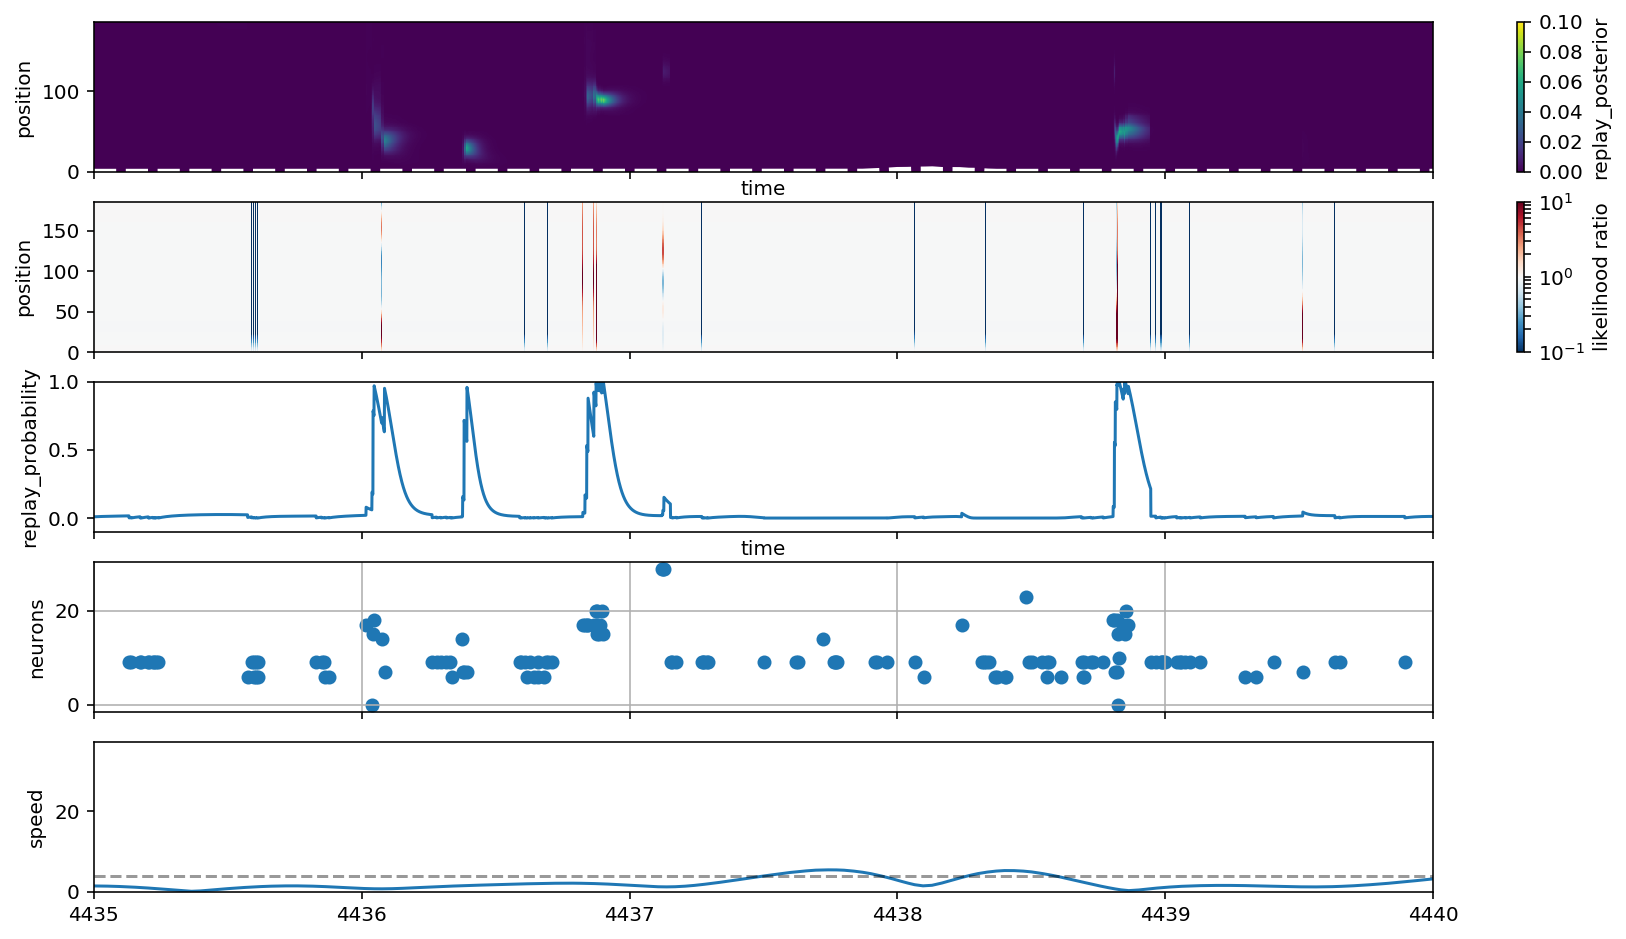

In [835]:
min_time, max_time = 4435, 4440
ind = (time > min_time) & (time < max_time)

fig, axes = plt.subplots(5, 1, figsize=(15, 8), sharex=True)
results.replay_posterior.sel(time=slice(min_time, max_time)).plot(
        x='time', y='position', ax=axes[0], vmin=0, vmax=0.1)
axes[0].plot(time[ind], linear_distance[ind],
             color='white', linestyle='--', linewidth=3)

likelihood = results.likelihood.sel(time=slice(min_time, max_time))
t, p = likelihood.time, likelihood.position
t, p = np.meshgrid(t, p)
cax = axes[1].pcolormesh(
    t, p, likelihood.values.T,
    norm=colors.LogNorm(1E-1, 1E1), cmap='RdBu_r')
axes[1].set_ylabel('position')
plt.colorbar(cax, ax=axes[1], label='likelihood ratio', orientation='vertical')

sm = plt.cm.ScalarMappable()
sm.set_array([])

results.sel(time=slice(min_time, max_time)).replay_probability.plot(ax=axes[2])
axes[2].set_ylim((-0.1, 1))
plt.colorbar(sm, ax=axes[2]).ax.set_visible(False)
plt.colorbar(sm, ax=axes[3]).ax.set_visible(False)
plt.colorbar(sm, ax=axes[4]).ax.set_visible(False)

time_ind, neuron_ind = np.nonzero(spikes[ind])
axes[3].scatter(time[ind][time_ind], neuron_ind)
axes[3].grid('on')
axes[3].set_ylabel('neurons')

axes[4].plot(time[ind], speed[ind])
axes[4].axhline(4, linestyle='--', alpha=0.4, color='black')
axes[4].set_ylim((0, np.nanmax(speed)))
axes[4].set_ylabel('speed');

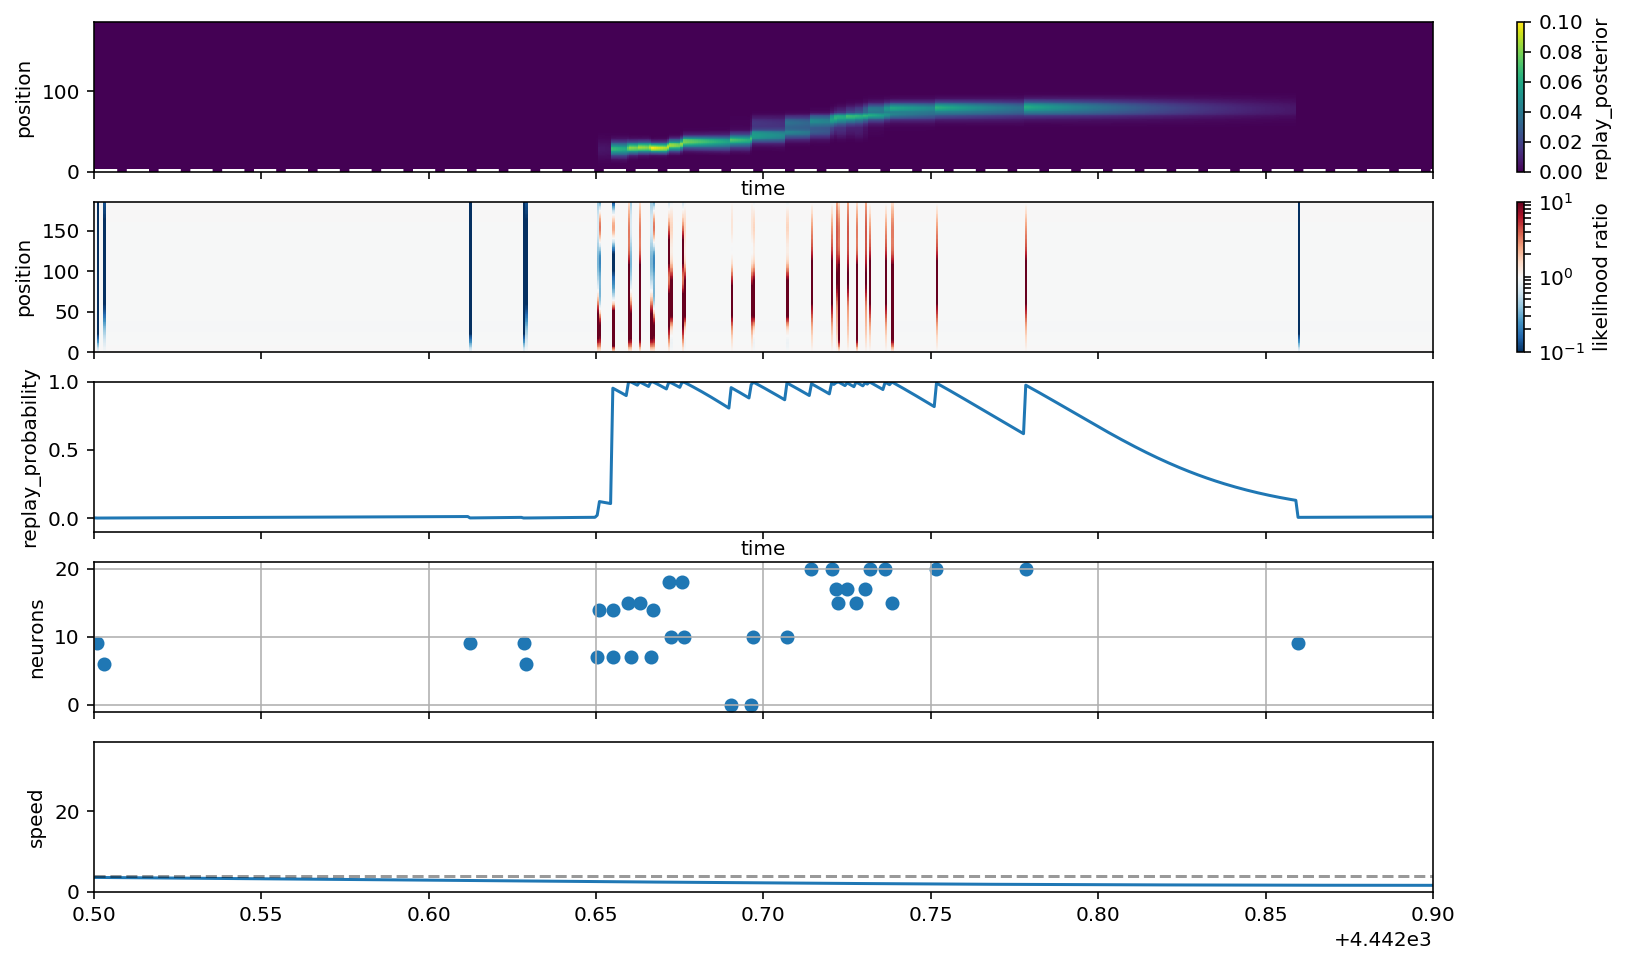

In [834]:
min_time, max_time = 4442.5, 4442.9
ind = (time > min_time) & (time < max_time)

fig, axes = plt.subplots(5, 1, figsize=(15, 8), sharex=True)
results.replay_posterior.sel(time=slice(min_time, max_time)).plot(
        x='time', y='position', ax=axes[0], vmin=0, vmax=0.1)
axes[0].plot(time[ind], linear_distance[ind],
             color='white', linestyle='--', linewidth=3)

likelihood = results.likelihood.sel(time=slice(min_time, max_time))
t, p = likelihood.time, likelihood.position
t, p = np.meshgrid(t, p)
cax = axes[1].pcolormesh(
    t, p, likelihood.values.T,
    norm=colors.LogNorm(1E-1, 1E1), cmap='RdBu_r')
axes[1].set_ylabel('position')
plt.colorbar(cax, ax=axes[1], label='likelihood ratio', orientation='vertical')

sm = plt.cm.ScalarMappable()
sm.set_array([])

results.sel(time=slice(min_time, max_time)).replay_probability.plot(ax=axes[2])
axes[2].set_ylim((-0.1, 1))
plt.colorbar(sm, ax=axes[2]).ax.set_visible(False)
plt.colorbar(sm, ax=axes[3]).ax.set_visible(False)
plt.colorbar(sm, ax=axes[4]).ax.set_visible(False)

time_ind, neuron_ind = np.nonzero(spikes[ind])
axes[3].scatter(time[ind][time_ind], neuron_ind)
axes[3].grid('on')
axes[3].set_ylabel('neurons')

axes[4].plot(time[ind], speed[ind])
axes[4].axhline(4, linestyle='--', alpha=0.4, color='black')
axes[4].set_ylim((0, np.nanmax(speed)))
axes[4].set_ylabel('speed');